# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
pandas.options.display.max_rows = 300

In [3]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR362YDM_26m_nuc'

In [4]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [5]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type

def calculate_v29_gene_base(gene_id):
    gene_base = gene_id.split('.')[0]
    if gene_id.endswith("_PAR_Y"):
        gene_base += "_PAR_Y"
    return gene_base
v29_gtf['gene_base'] = v29_gtf['gene_id'].apply(calculate_v29_gene_base)

In [6]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_id] = row.gene_name
    v32m_gene_id_to_type[row.gene_id] = row.gene_type

In [7]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered", multiread="Unique"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    MULTIREAD_MATRIX = {
    "Unique": "matrix.mtx",
    "Rescue": "UniqueAndMult-Rescue.mtx",
    "EM": "UniqueAndMult-EM.mtx",
    }
    assert multiread in MULTIREAD_MATRIX

    analysis_dir = Path(analysis_dir)
    
    solo_dir = analysis_dir / "Solo.out" / quantification 
    solo = scanpy.read_mtx(solo_dir / "raw" / MULTIREAD_MATRIX[multiread]).T
    solo_vars = pandas.read_csv(
        solo_dir / "raw" / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "raw" / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]
    
    if mode == "filtered":
        solo_obs = pandas.read_csv(
            solo_dir / mode / "barcodes.tsv", header=None, sep="\t"
        ).values.T[0]
        solo = solo[solo_obs,:]
        

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



I tried to do an analysis using the the different modes of soloMultiMappers but they seemed too similar.
Then I computed the md5sum of the matrix files... and yeah the argument didn't seem to do anything.

<table>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_em_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_rescue_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_em_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_rescue_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
</table>

I also learned that there's some gene base ids that have two version varients. (One example)
<table>
<tr><td>gene_id 	</td><td>gene_name 	</td><td>gene_type</td></tr>
<tr><td>ENSG00000169084.13 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
    <tr><td>ENSG00000169084.13_PAR_Y 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
</table>

# Load Datasets

In [8]:
algorithm_roots = {
    'tenx solo uniq': (Path("tenxsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Unique"),
    'tenx solo rescue': (Path("tenxsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Rescue"),
    'tenx solo em': (Path("tenxsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "EM"),
    
    'encode full solo uniq': (Path("fullsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Unique"),
    'encode full solo rescue': (Path("fullsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Rescue"),
    'encode full solo em': (Path("fullsolo_multi_2.7.9a_2021-06-25"),  "GeneFull", "filtered", "EM"),

    'encode minimal solo uniq': (Path("minimalsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Unique"),
    'encode minimal solo rescue': (Path("minimalsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Rescue"),
    'encode minimal solo em': (Path("minimalsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "EM"),
}

In [9]:
algorithm_filtered = {}
for algorithm in algorithm_roots:
    root, quantification, filtering, multiread = algorithm_roots[algorithm]
    print("loading {}".format(algorithm))
    algorithm_filtered[algorithm] = scanpy_load_solo278a_mtx(root, quantification, filtering, multiread)
    print(algorithm, algorithm_filtered[algorithm].shape, algorithm_filtered[algorithm].X.sum())

loading tenx solo uniq


Trying to set attribute `.obs` of view, copying.


tenx solo uniq (11964, 36601) 61086730.0
loading tenx solo rescue


Trying to set attribute `.obs` of view, copying.


tenx solo rescue (11964, 36601) 63897140.0
loading tenx solo em


Trying to set attribute `.obs` of view, copying.


tenx solo em (11964, 36601) 63897140.0
loading encode full solo uniq


Trying to set attribute `.obs` of view, copying.


encode full solo uniq (11736, 59526) 57945816.0
loading encode full solo rescue


Trying to set attribute `.obs` of view, copying.


encode full solo rescue (11736, 59526) 64361504.0
loading encode full solo em


Trying to set attribute `.obs` of view, copying.


encode full solo em (11736, 59526) 64361492.0
loading encode minimal solo uniq


Trying to set attribute `.obs` of view, copying.


encode minimal solo uniq (11835, 28249) 57073864.0
loading encode minimal solo rescue


Trying to set attribute `.obs` of view, copying.


encode minimal solo rescue (11835, 28249) 61426036.0
loading encode minimal solo em


Trying to set attribute `.obs` of view, copying.


encode minimal solo em (11835, 28249) 61426030.0


# Add (faked) version to 10x annotation

The 10x provided annotation GTF file, based on GENCODE V32, has the gene version number removed, to make later comparisons easier I added the gene version number from my V29 GTF on to the V32 gene base ids.

(Gene base = ENSG00000243485)

(Gene id with version = ENSG00000243485.5)

In [10]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945'],
      dtype='object')

In [11]:
for algorithm in algorithm_filtered:
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var_names = v32m_gtf.set_index('gene_base').reindex(algorithm_filtered[algorithm].var_names.to_list())['gene_id']

In [12]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485.5', 'ENSG00000237613.2', 'ENSG00000186092.6',
       'ENSG00000238009.6', 'ENSG00000239945.1'],
      dtype='object', name='gene_id')

# Remove version from ENCODE annotations

In [13]:
#algorithm_filtered['encode minimal solo uniq'].var_names

In [14]:
#for algorithm in algorithm_filtered:
#    if algorithm != 'tenx solo uniq':
#        algorithm_filtered[algorithm].var_names = [x.split('.')[0] for x in algorithm_filtered[algorithm].var_names]


In [15]:
#algorithm_filtered['encode minimal solo uniq'].var_names

# Cell barcodes in common

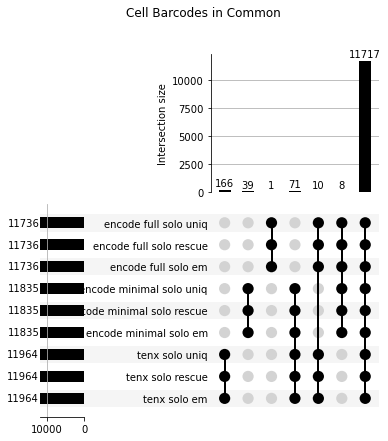

In [16]:
algorithm_cell_barcodes = {}
for algorithm in algorithm_filtered:
    algorithm_cell_barcodes[algorithm] = algorithm_filtered[algorithm].obs_names

common_cell_barcode_set = upsetplot.from_contents(algorithm_cell_barcodes)
f = pyplot.figure()
f.suptitle("Cell Barcodes in Common")
_ = upsetplot.plot(common_cell_barcode_set, fig=f, show_counts=True)


# Gene IDs in common

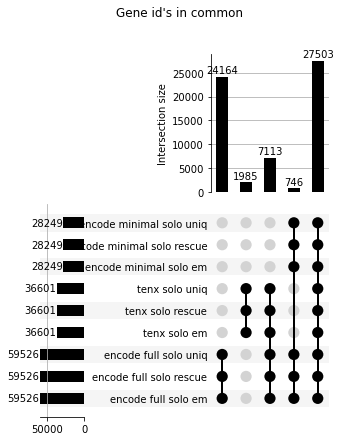

In [17]:
algorithm_gene_base_ids = {}
for algorithm in algorithm_filtered:
    algorithm_gene_base_ids[algorithm] = set(algorithm_filtered[algorithm].var_names)

common_gene_base_contents = upsetplot.from_contents(algorithm_gene_base_ids)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
f = pyplot.figure()
f.suptitle("Gene id's in common")
_ = upsetplot.plot(common_gene_base_contents, fig=f, show_counts=True)

# What are some of those genes in tenx & encode full 

In [18]:
common_gene_base_contents

id
tenx solo uniq tenx solo rescue tenx solo em encode full solo uniq encode full solo rescue encode full solo em encode minimal solo uniq encode minimal solo rescue encode minimal solo em                    
True           True             True         True                  True                    True                True                     True                       True                     ENSG00000076043.9
                                             False                 False                   False               False                    False                      False                      ENSG00000286207
                                                                                                                                                                   False                      ENSG00000287992
                                             True                  True                    True                True                     True                       True                    ENSG00000141759.14
                                                                                                               False                    False                      False                    ENSG00000284294.1
...                                                                                                                                                                                                       ...
False          False            False        True                  True                    True                False                    False                      False                    ENSG00000278872.1
                                                                                                                                                                   False                    ENSG00000236674.1
                                                                                                                                                                   False                    ENSG00000261575.2
                                                                                                                                                                   False                    ENSG00000283101.1
                                                                                                                                                                   False                    ENSG00000180662.8

[61511 rows x 1 columns]

In [19]:
not_in_encode_minimal = common_gene_base_contents.loc[True,True,True,True,True,True,False,False,False]['id'].values

changed_between_versions = []
for gene_base in not_in_encode_minimal:
    changed_between_versions.append({
        'gene_base': gene_base,
        'v29_type': v29_gene_id_to_type[gene_base],
        'v32_type': v32m_gene_id_to_type[gene_base],
    })
    
changed_between_versions = pandas.DataFrame(changed_between_versions)

<ipython-input-19-f9b6b4ac231c>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  not_in_encode_minimal = common_gene_base_contents.loc[True,True,True,True,True,True,False,False,False]['id'].values


In [20]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]

gene_base              v29_type v32_type
0     ENSG00000284294.1  processed_transcript   lncRNA
1     ENSG00000255443.1             antisense   lncRNA
2     ENSG00000253586.1        sense_intronic   lncRNA
3     ENSG00000235740.1             antisense   lncRNA
4     ENSG00000233078.1             antisense   lncRNA
...                 ...                   ...      ...
7108  ENSG00000259536.5             antisense   lncRNA
7109  ENSG00000285651.1             antisense   lncRNA
7110  ENSG00000271360.1             antisense   lncRNA
7111  ENSG00000229042.2             antisense   lncRNA
7112  ENSG00000255750.5             antisense   lncRNA

[7113 rows x 3 columns]

In [21]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]['v32_type'].unique()

array(['lncRNA', 'protein_coding'], dtype=object)

# Build list of cells and gene ids in common between all runs

In [22]:
common_cell_barcode_set = None
for algorithm in algorithm_filtered:
    if common_cell_barcode_set is None:
        common_cell_barcode_set = set(algorithm_filtered[algorithm].obs_names)
    else:
        common_cell_barcode_set = common_cell_barcode_set.intersection(algorithm_filtered[algorithm].obs_names)

print('common_cell_barcode_set', len(common_cell_barcode_set))
common_cell_barcodes = [x for x in algorithm_filtered['encode full solo uniq'].obs_names if x in common_cell_barcode_set]
print('common_cell_barcodes', len(common_cell_barcodes))


common_cell_barcode_set 11717
common_cell_barcodes 11717


In [23]:
common_gene_id_set = None
for algorithm in algorithm_filtered:
    #if algorithm == 'tenx solo uniq':
    #    continue
    if common_gene_id_set is None:
        common_gene_id_set = set(algorithm_filtered[algorithm].var_names)
    else:
        common_gene_id_set = common_gene_id_set.intersection(algorithm_filtered[algorithm].var_names)

print("common_gene_id_set", len(common_gene_id_set), len(set(common_gene_id_set)))
common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x in common_gene_id_set]
print("common_gene_ids", len(common_gene_ids), len(set(common_gene_ids)))

common_gene_id_set 27503 27503
common_gene_ids 27503 27503


In [24]:
#tenx_gene_base = set(algorithm_filtered['tenx solo uniq'].var_names)
#v29_common_gene_base = [x.split('.')[0] for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#v29_common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#print(len(v29_common_gene_base), v29_common_gene_base[:5])

In [25]:
algorithm_common = {}
for algorithm in algorithm_filtered:
    algorithm_common[algorithm] = algorithm_filtered[algorithm][common_cell_barcodes, common_gene_ids]
    print(algorithm, algorithm_common[algorithm].shape, algorithm_common[algorithm].X.sum())

tenx solo uniq (11717, 27503) 58525600.0
tenx solo rescue (11717, 27503) 61015356.0
tenx solo em (11717, 27503) 61080850.0
encode full solo uniq (11717, 27503) 54862280.0
encode full solo rescue (11717, 27503) 58875150.0
encode full solo em (11717, 27503) 58977324.0
encode minimal solo uniq (11717, 27503) 56741380.0
encode minimal solo rescue (11717, 27503) 59849296.0
encode minimal solo em (11717, 27503) 59728110.0


# Compute correlations of cells in common between all methods

In [26]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.to_df().T
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.to_df().T

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


def compute_correlations(table):
    programs = list(table.keys())
    correlations = {}
    dense = {}
    for name_x in programs:
        dense[name_x] = table[name_x].to_df().T

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            print("Processing {} {}".format(name_x, name_y))
            cs_cors = compute_spearman_anndata(dense[name_x], dense[name_y])
            correlations.setdefault(name_x, {})[name_y] = cs_cors
    return correlations

algorithm_correlations = compute_correlations(algorithm_common)

Processing tenx solo uniq tenx solo uniq
Processing tenx solo uniq tenx solo rescue
Processing tenx solo uniq tenx solo em
Processing tenx solo uniq encode full solo uniq
Processing tenx solo uniq encode full solo rescue
Processing tenx solo uniq encode full solo em
Processing tenx solo uniq encode minimal solo uniq
Processing tenx solo uniq encode minimal solo rescue
Processing tenx solo uniq encode minimal solo em
Processing tenx solo rescue tenx solo rescue
Processing tenx solo rescue tenx solo em
Processing tenx solo rescue encode full solo uniq
Processing tenx solo rescue encode full solo rescue
Processing tenx solo rescue encode full solo em
Processing tenx solo rescue encode minimal solo uniq
Processing tenx solo rescue encode minimal solo rescue
Processing tenx solo rescue encode minimal solo em
Processing tenx solo em tenx solo em
Processing tenx solo em encode full solo uniq
Processing tenx solo em encode full solo rescue
Processing tenx solo em encode full solo em
Processing

In [27]:
def plot_cell_correlation_histogram(table, title=None, bins=50, programs=None):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = numpy.array(table[name_x][name_y])
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()
    

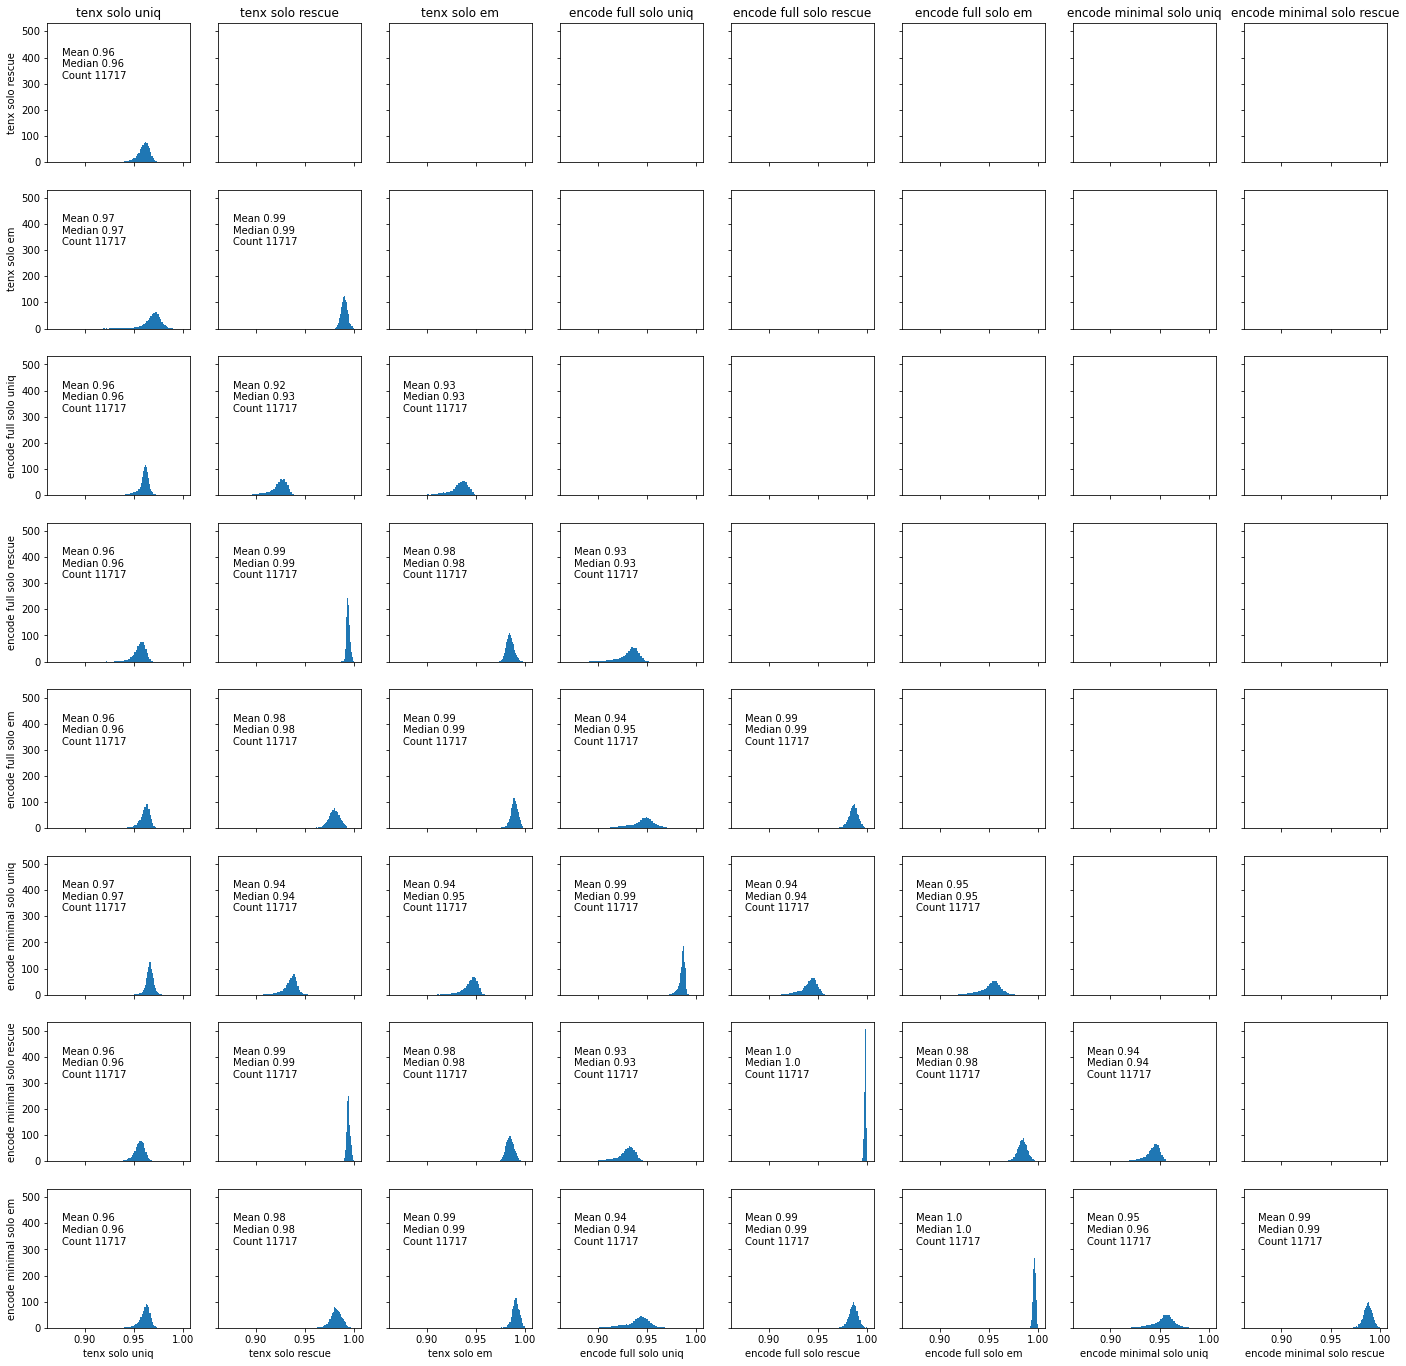

In [28]:
plot_cell_correlation_histogram(algorithm_correlations)

# Scatter plot of method genes in common over all cells

In [29]:
def plot_algorithm_sums(table, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)    
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            scatter.setdefault(name_x, {})[name_y] = ax.scatter(
                numpy.asarray(table[name_x].X.sum(axis=1).T)[0], 
                numpy.asarray(table[name_y].X.sum(axis=1).T)[0],
                s=0.5
            )
            ax.set_xscale('log')
            ax.set_yscale('log')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("per algorithm sum of genes over all cells")
    #f.tight_layout()
    

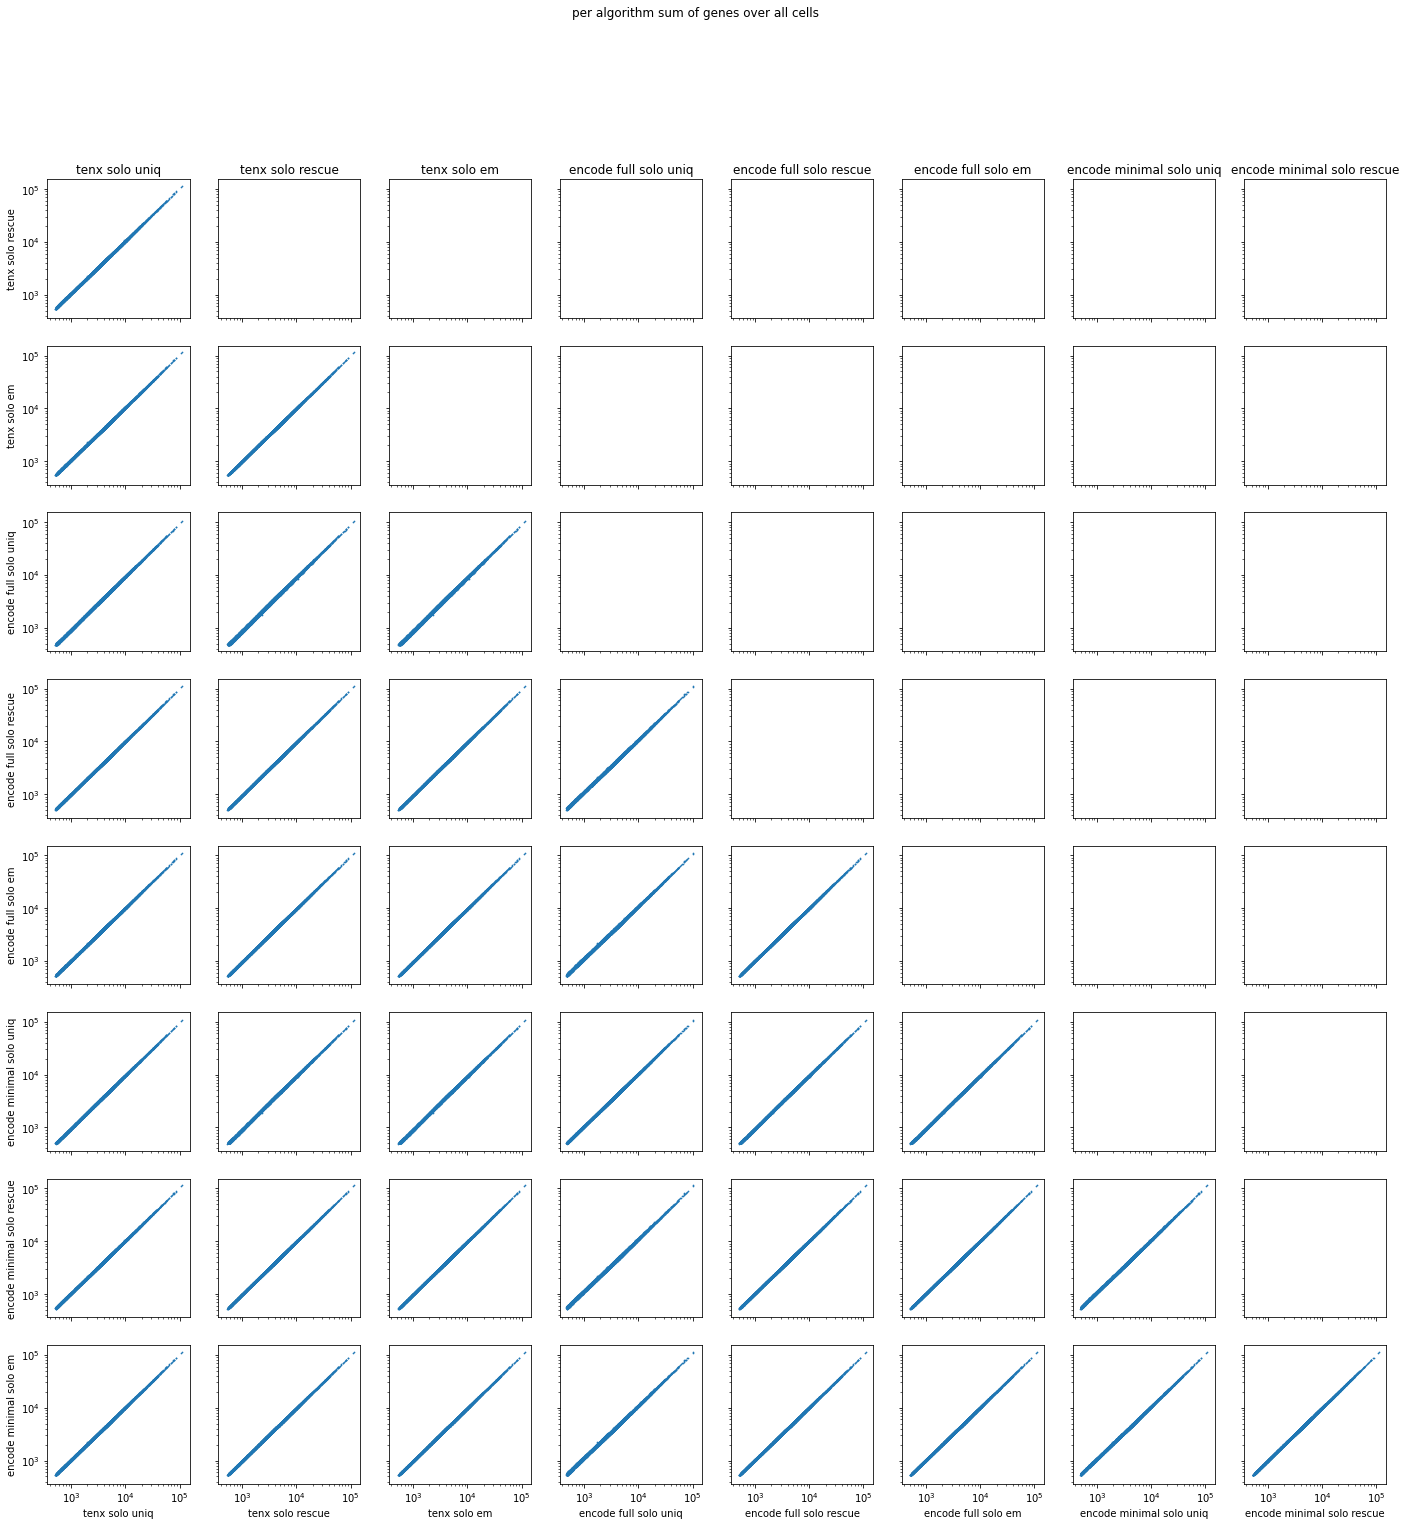

In [30]:
plot_algorithm_sums(algorithm_common)

# Scatter plots of gene expression for worst, median, and best correlated cells

In [31]:
algorithm_dense = {}
for algorithm in algorithm_common:
    algorithm_dense[algorithm] = algorithm_common[algorithm].to_df().T


In [32]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    ax.scatter(numpy.log2(table[name_x][cell_id]+0.01), numpy.log2(table[name_y][cell_id]+0.01), color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    expressed_in_x = table[name_x][cell_id] > 0
    expressed_in_y = table[name_y][cell_id] > 0
    count = table[name_x][expressed_in_x & expressed_in_y].shape[0]
    ax.set_title(f'id {cell_id}\nSpearman {spearman:0.4}\nCount: {count}')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, name_x, name_y, best_cell, ax=axes[2])
    return f

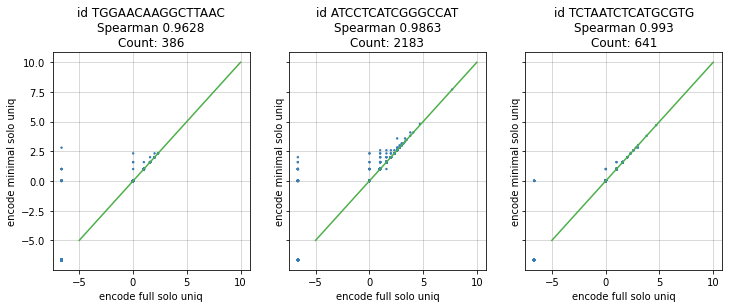

In [33]:
f = show_scatter_extremes(algorithm_dense, algorithm_correlations,'encode full solo uniq', 'encode minimal solo uniq')

<ipython-input-32-408e00a00fee>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pyplot.figure(figsize=(12,4))


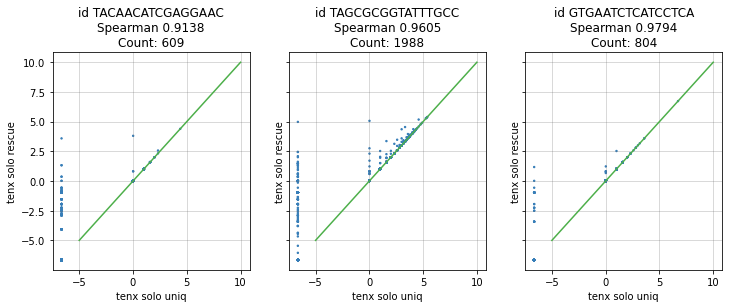

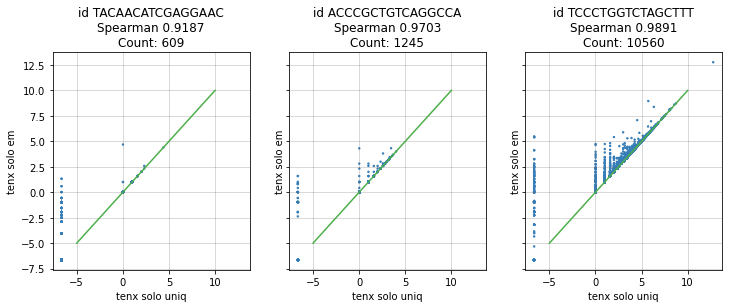

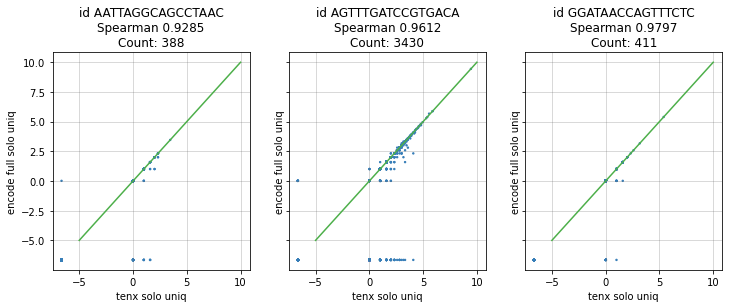

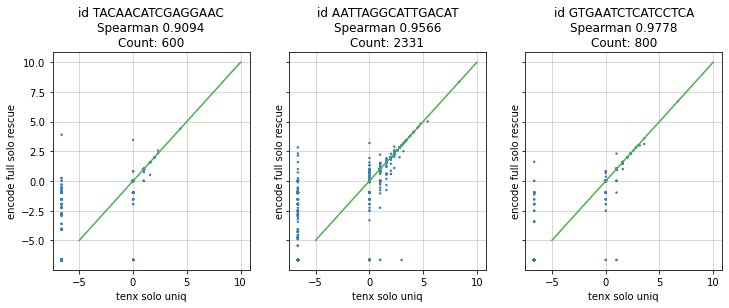

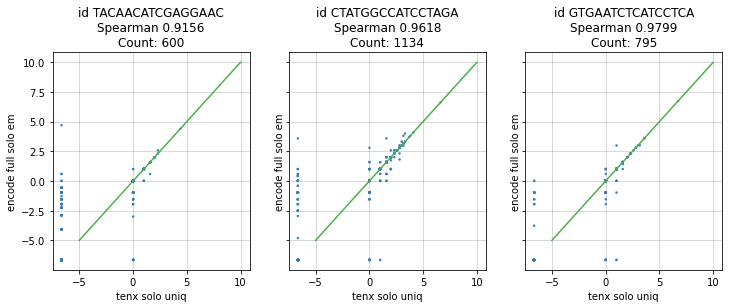

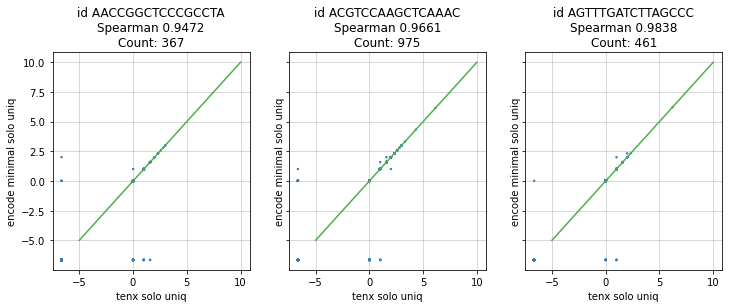

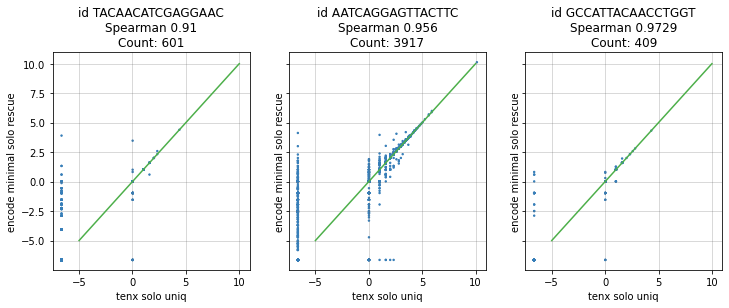

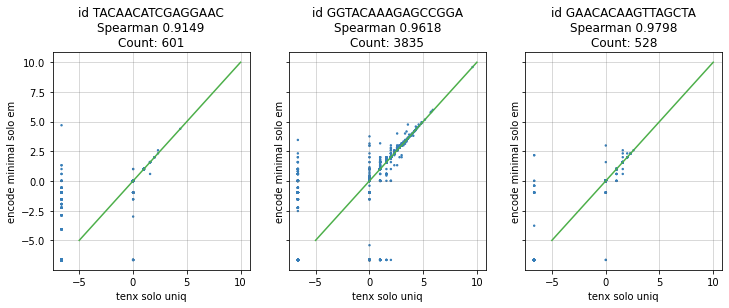

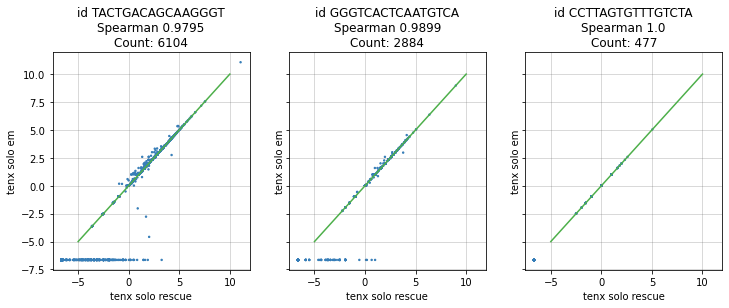

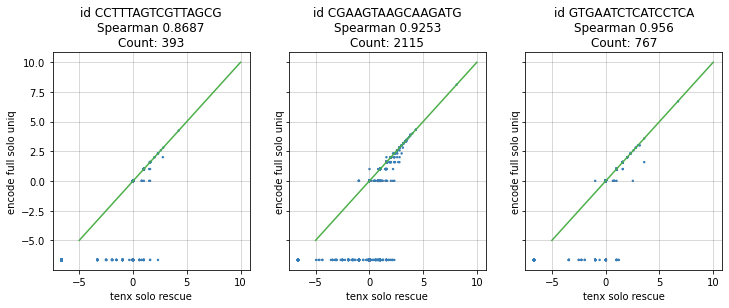

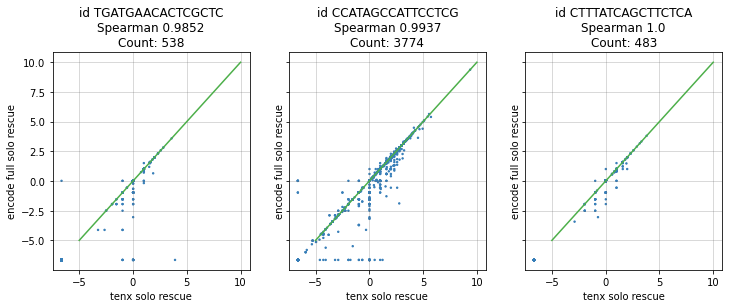

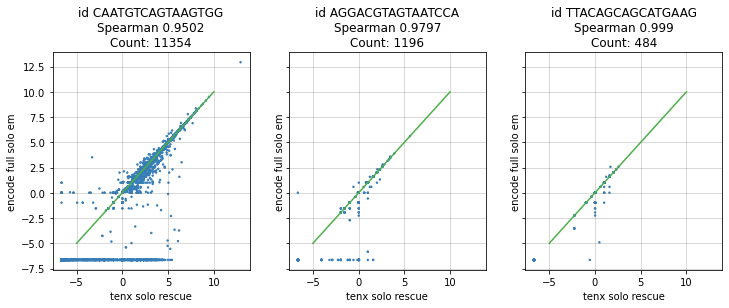

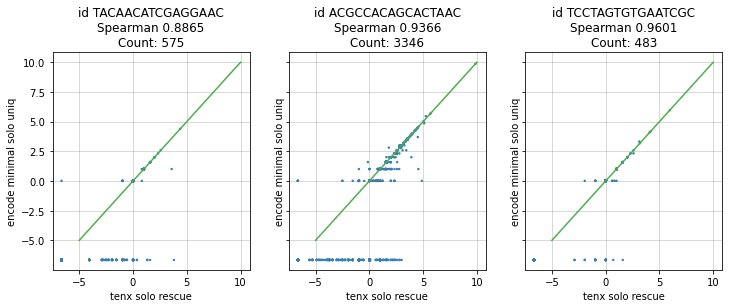

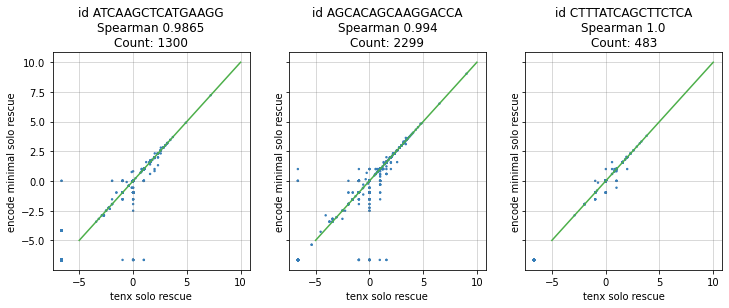

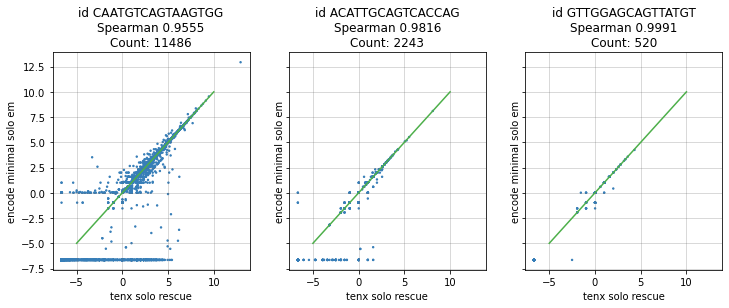

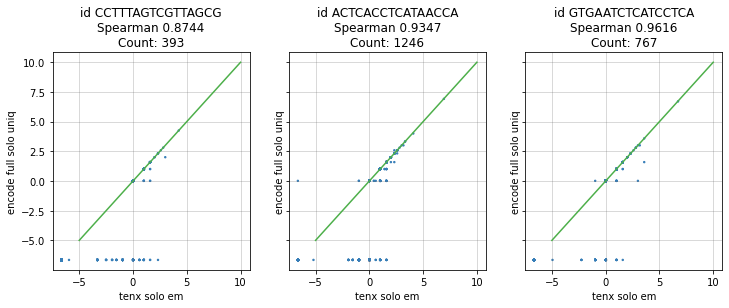

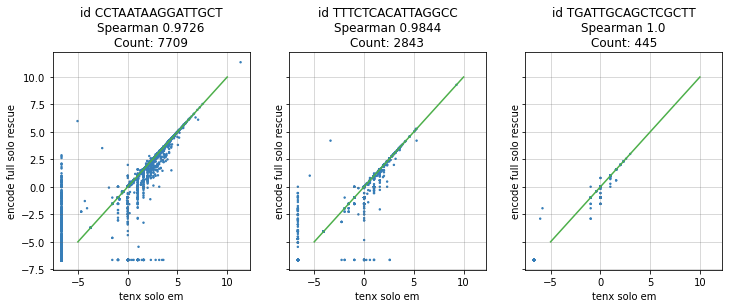

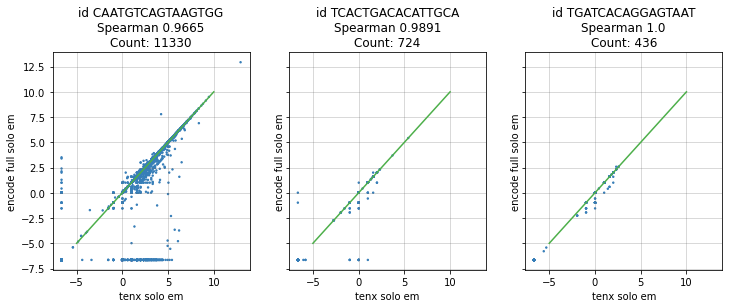

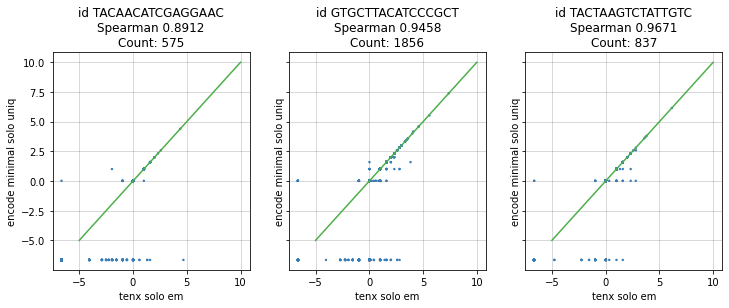

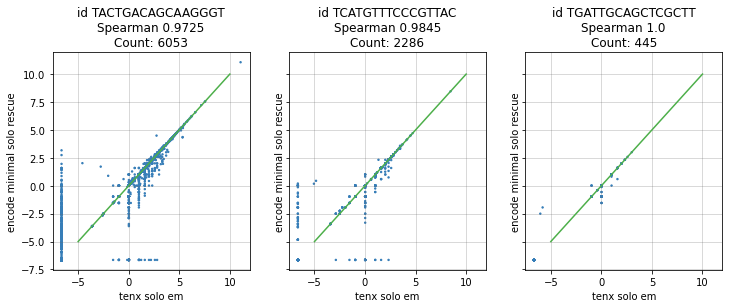

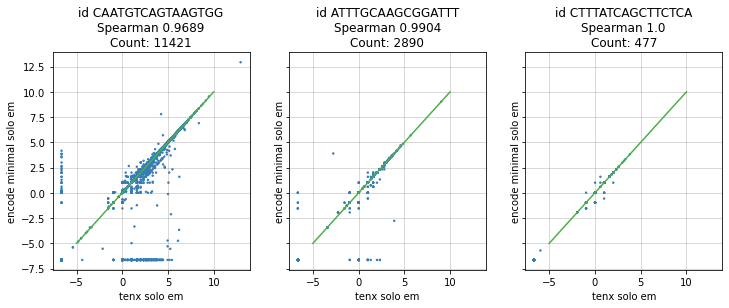

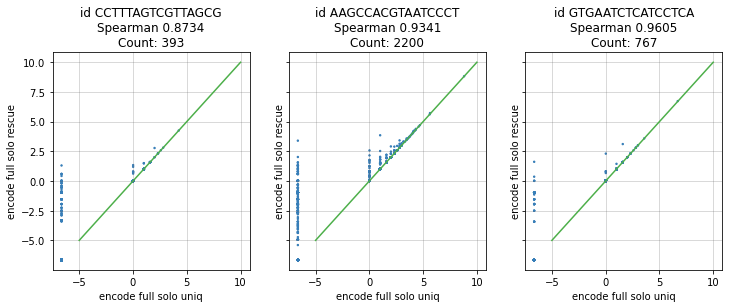

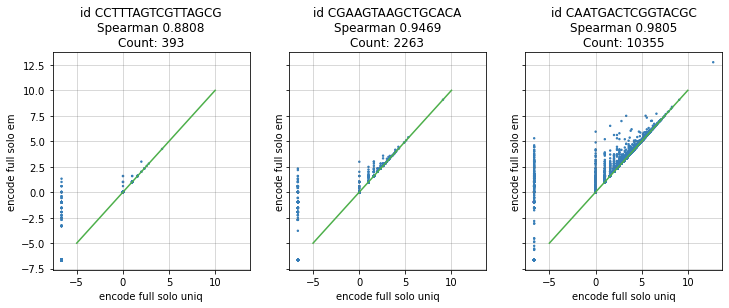

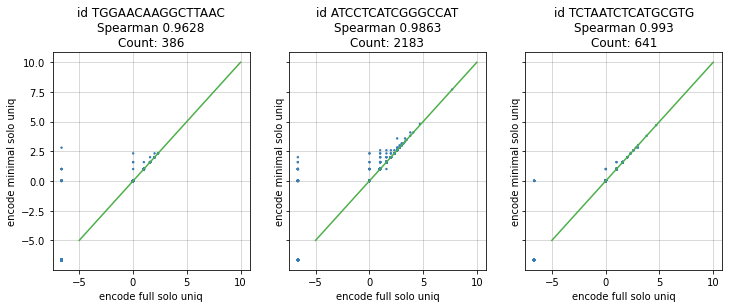

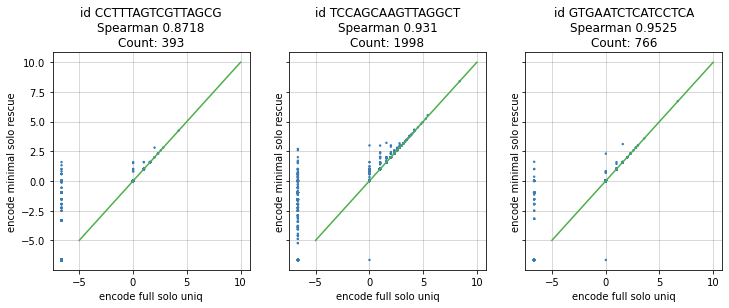

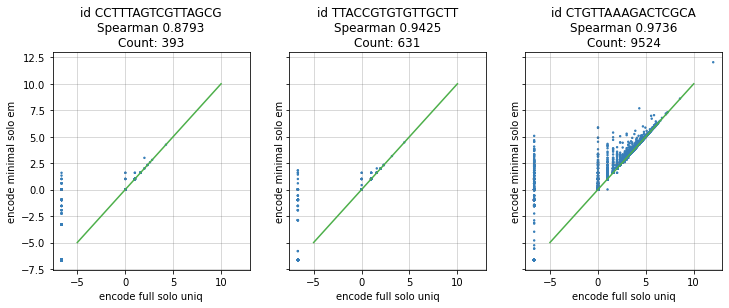

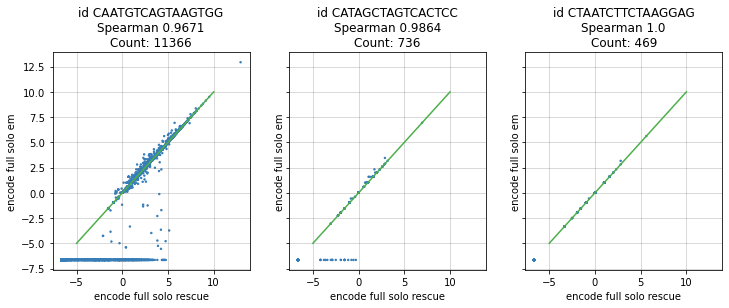

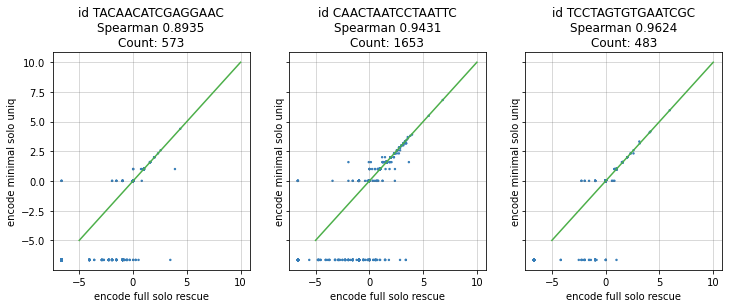

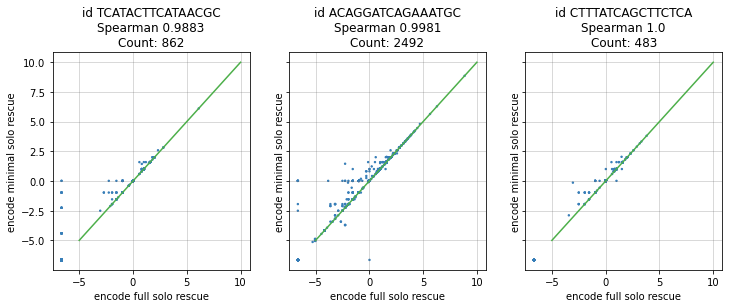

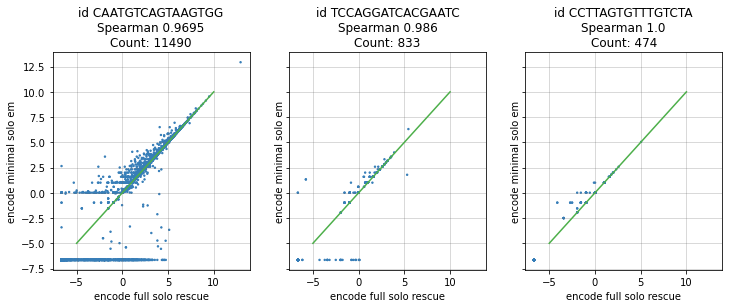

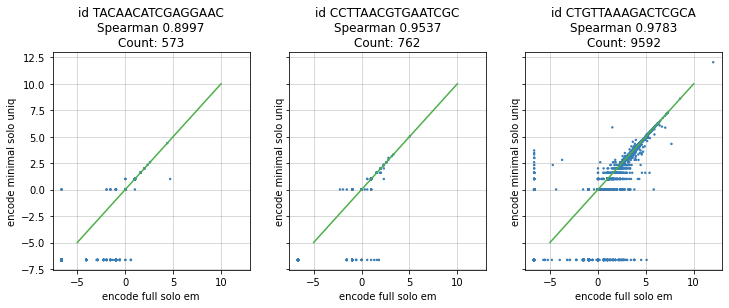

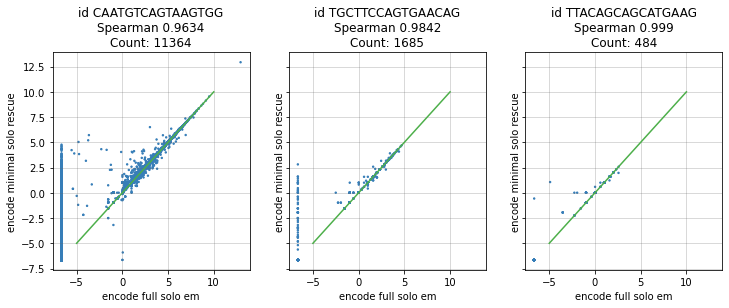

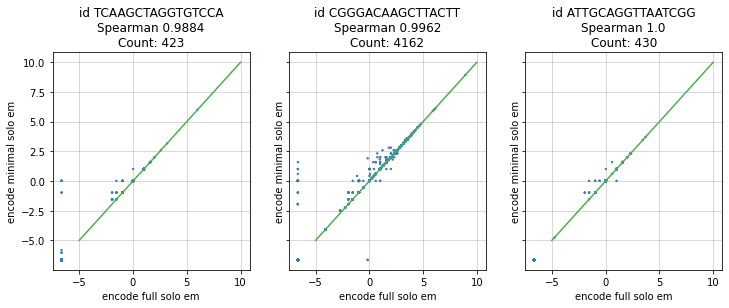

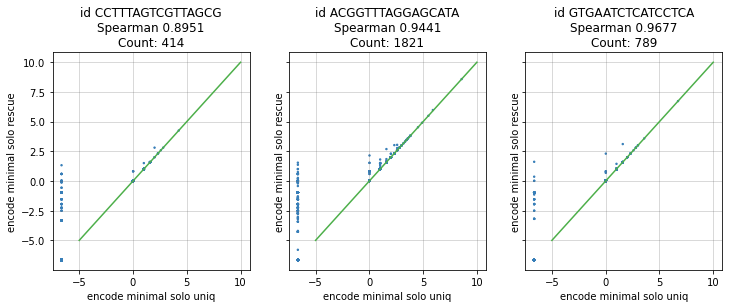

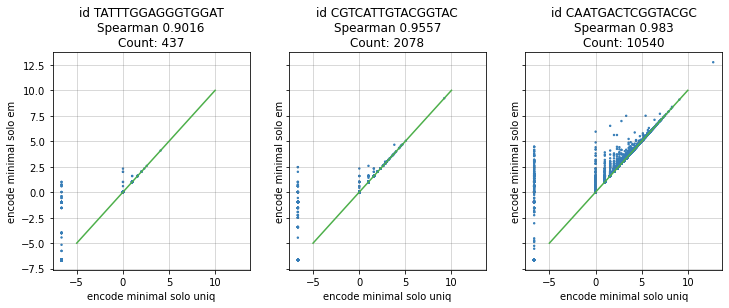

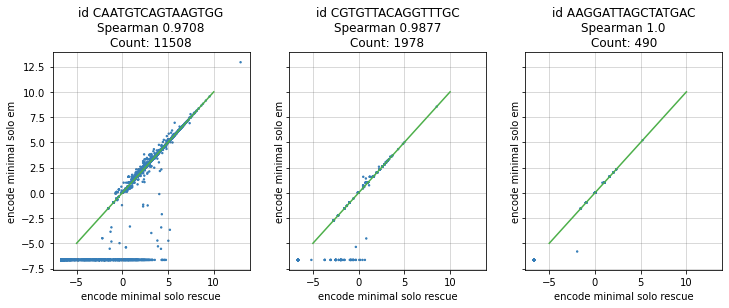

In [34]:
def plot_all_scatter_extremes(table, correlations):
    programs = list(table.keys())


    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            #print("Comparing {} {}".format(name_x, name_y))
            f = show_scatter_extremes(table, correlations, name_x, name_y)
            
            
plot_all_scatter_extremes(algorithm_dense, algorithm_correlations)

# Scatter plot of cells with the highest expression sum

In [35]:
def plot_algorithm_most_expressed(table, correlations, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))


    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            max_cell = algorithm_dense[name_x].sum(axis=0).idxmax()
            scatter.setdefault(name_x, {})[name_y] = sc_scatter(table, correlations, name_x, name_y, max_cell, ax=ax)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Compare algorithms with cell with highest expression sum")
    #f.tight_layout()
    

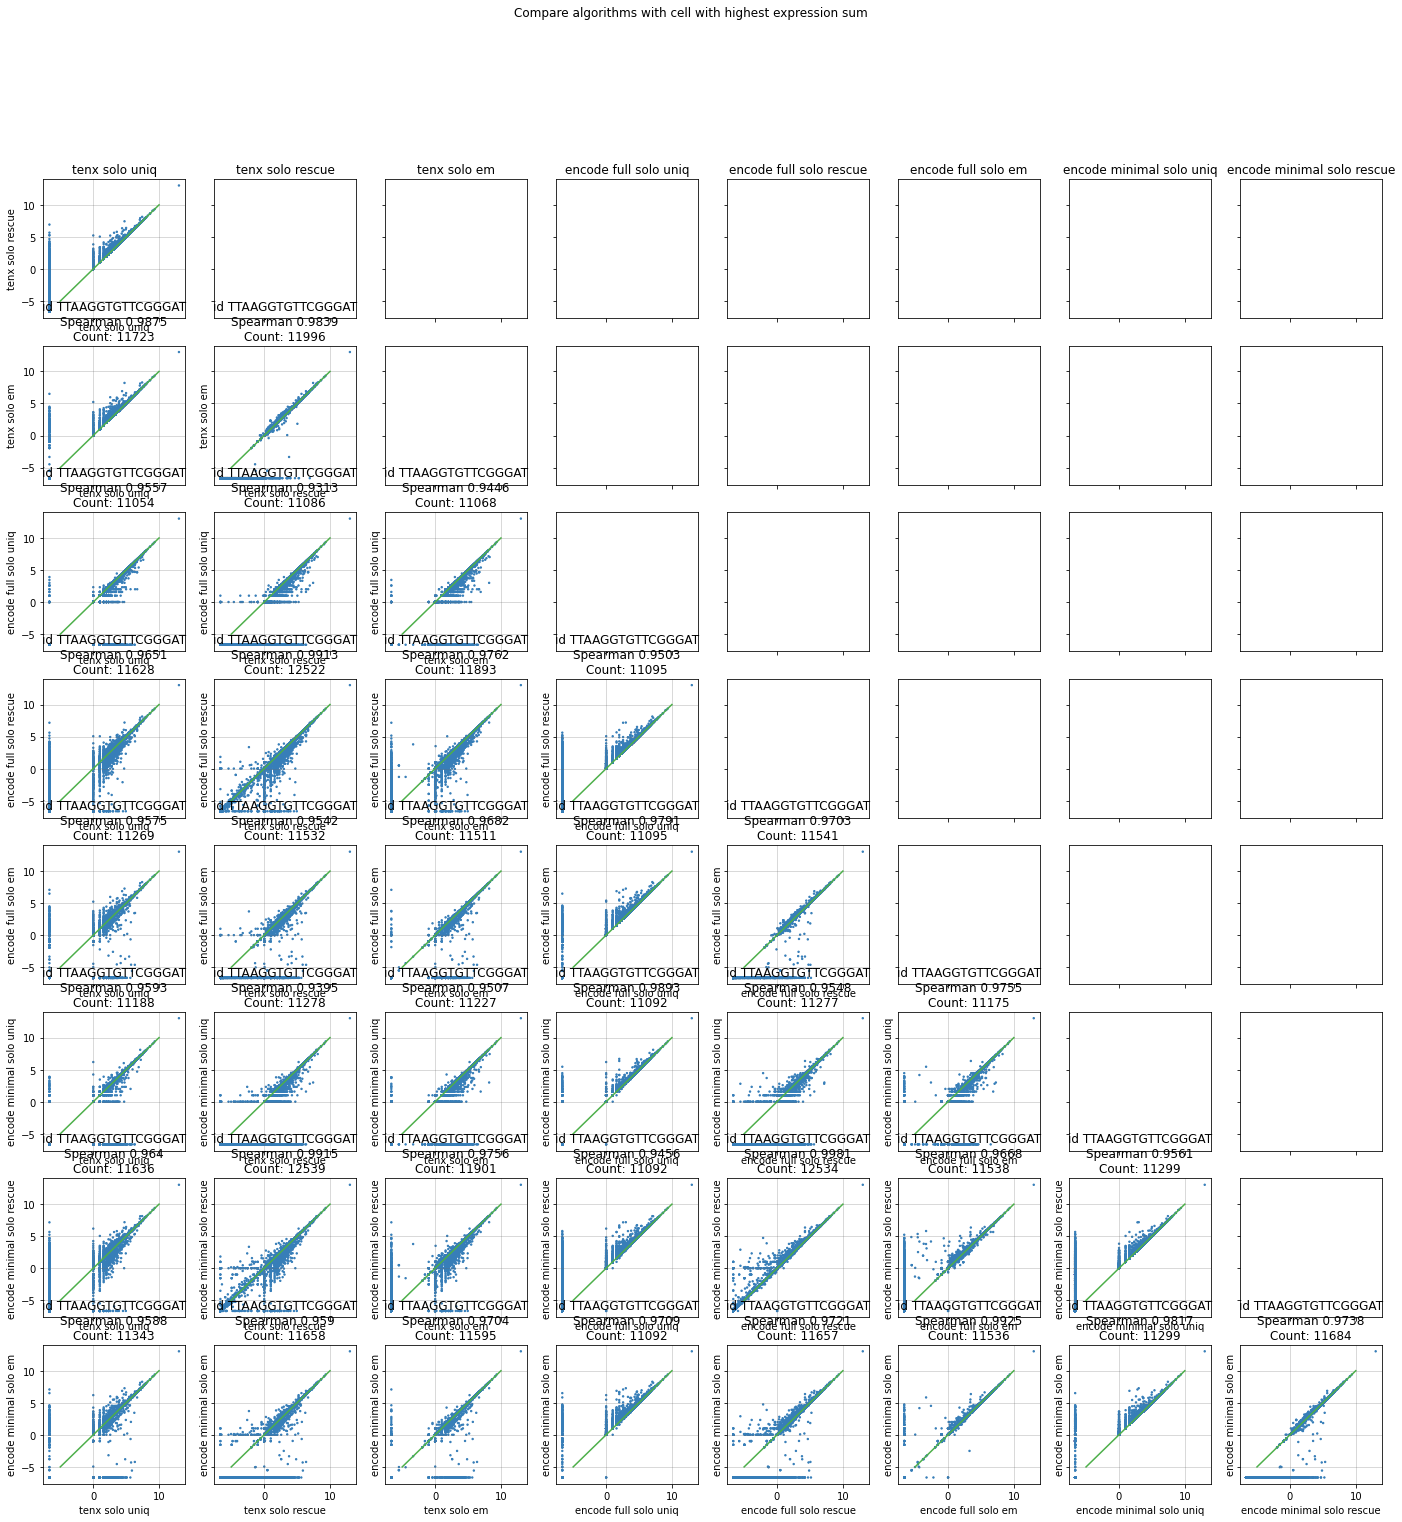

In [36]:
plot_algorithm_most_expressed(algorithm_dense, algorithm_correlations)

It seems weird that there's expression in encode minimal, but not in encode full, maybe I have the labels backward?

In [37]:
encode_minimal_uniq_sum = algorithm_dense['encode minimal solo uniq'].sum(axis=1)
encode_full_uniq_sum = algorithm_dense['encode full solo uniq'].sum(axis=1)

In [38]:
in_minimal_uniq_sum = encode_minimal_uniq_sum > 0
not_in_minimal_uniq_sum = encode_minimal_uniq_sum == 0
in_full_uniq_sum = encode_full_uniq_sum > 0
not_in_full_uniq_sum =(encode_full_uniq_sum == 0)

encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum]

ENSG00000225880.5       270.0
ENSG00000237330.2         1.0
ENSG00000158786.4         1.0
ENSG00000142789.19       13.0
ENSG00000270103.3        40.0
ENSG00000214114.8       315.0
ENSG00000270457.1         8.0
ENSG00000229943.1         1.0
ENSG00000243480.7         2.0
ENSG00000196427.13        1.0
ENSG00000270066.3        37.0
ENSG00000236334.2        29.0
ENSG00000215853.3         1.0
ENSG00000236427.1         9.0
ENSG00000173110.7       179.0
ENSG00000235736.1        13.0
ENSG00000203601.3       826.0
ENSG00000224810.1         8.0
ENSG00000231714.1         1.0
ENSG00000243636.1        48.0
ENSG00000281664.1        18.0
ENSG00000278467.1        32.0
ENSG00000270188.1         1.0
ENSG00000242042.1         1.0
ENSG00000228198.3         2.0
ENSG00000243943.9      1796.0
ENSG00000273006.1         2.0
ENSG00000187600.14        6.0
ENSG00000171150.8      7225.0
ENSG00000055813.5       353.0
ENSG00000237651.6      2706.0
ENSG00000281920.1        34.0
ENSG00000222041.11     3101.0
ENSG000001

# Quick glance at genes that are expressed in just in the minimal set

In [39]:
v29_gtf.set_index('gene_id').reindex(encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum].index)

gene_name       gene_type        gene_base
ENSG00000225880.5    LINC00115         lincRNA  ENSG00000225880
ENSG00000237330.2       RNF223  protein_coding  ENSG00000237330
ENSG00000158786.4      PLA2G2F  protein_coding  ENSG00000158786
ENSG00000142789.19      CELA3A  protein_coding  ENSG00000142789
ENSG00000270103.3   AL360012.1         lincRNA  ENSG00000270103
ENSG00000214114.8        MYCBP  protein_coding  ENSG00000214114
ENSG00000270457.1   AC093424.1         lincRNA  ENSG00000270457
ENSG00000229943.1   AC133865.1         lincRNA  ENSG00000229943
ENSG00000243480.7        AMY2A  protein_coding  ENSG00000243480
ENSG00000196427.13       NBPF4  protein_coding  ENSG00000196427
ENSG00000270066.3   AL356488.2         lincRNA  ENSG00000270066
ENSG00000236334.2      PPIAL4G  protein_coding  ENSG00000236334
ENSG00000215853.3         RPTN  protein_coding  ENSG00000215853
ENSG00000236427.1   AL589986.2         lincRNA  ENSG00000236427
ENSG00000173110.7        HSPA6  protein_coding  ENSG00000173110
ENSG00000235736.1   AL031275.1         lincRNA  ENSG00000235736
ENSG00000203601.3    LINC00970         lincRNA  ENSG00000203601
ENSG00000224810.1   AL355482.1         lincRNA  ENSG00000224810
ENSG00000231714.1   AL513348.1         lincRNA  ENSG00000231714
ENSG00000243636.1   AL445493.2         lincRNA  ENSG00000243636
ENSG00000281664.1    LINC00538         lincRNA  ENSG00000281664
ENSG00000278467.1   AC138393.3         lincRNA  ENSG00000278467
ENSG00000270188.1    MTRNR2L11  protein_coding  ENSG00000270188
ENSG00000242042.1    LINC01743         lincRNA  ENSG00000242042
ENSG00000228198.3        OR2M3  protein_coding  ENSG00000228198
ENSG00000243943.9       ZNF512  protein_coding  ENSG00000243943
ENSG00000273006.1   AC009229.3         lincRNA  ENSG00000273006
ENSG00000187600.14   LINC02583         lincRNA  ENSG00000187600
ENSG00000171150.8        SOCS5  protein_coding  ENSG00000171150
ENSG00000055813.5      CCDC85A  protein_coding  ENSG00000055813
ENSG00000237651.6      C2orf74  protein_coding  ENSG00000237651
ENSG00000281920.1   AC007389.5         lincRNA  ENSG00000281920
ENSG00000222041.11       CYTOR         lincRNA  ENSG00000222041
ENSG00000125551.18      PLGLB2  protein_coding  ENSG00000125551
ENSG00000211592.8         IGKC       IG_C_gene  ENSG00000211592
ENSG00000211593.2        IGKJ5       IG_J_gene  ENSG00000211593
ENSG00000211594.2        IGKJ4       IG_J_gene  ENSG00000211594
ENSG00000228251.1   AC012442.1         lincRNA  ENSG00000228251
ENSG00000177519.3         RPRM  protein_coding  ENSG00000177519
ENSG00000285373.1    LINC02478         lincRNA  ENSG00000285373
ENSG00000271141.1   AC010680.4         lincRNA  ENSG00000271141
ENSG00000271401.1   AC010680.5         lincRNA  ENSG00000271401
ENSG00000174325.5        DIRC1  protein_coding  ENSG00000174325
ENSG00000227418.6       PCGEM1         lincRNA  ENSG00000227418
ENSG00000247626.4        MARS2  protein_coding  ENSG00000247626
ENSG00000237940.3    LINC01238         lincRNA  ENSG00000237940
ENSG00000231401.1   AC023481.1         lincRNA  ENSG00000231401
ENSG00000224884.1   AC034187.1         lincRNA  ENSG00000224884
ENSG00000261734.1   AC116096.1         lincRNA  ENSG00000261734
ENSG00000010282.14       HHATL  protein_coding  ENSG00000010282
ENSG00000273211.1   AC137630.4         lincRNA  ENSG00000273211
ENSG00000270562.1   AC097634.1         lincRNA  ENSG00000270562
ENSG00000272840.1   AC092902.3         lincRNA  ENSG00000272840
ENSG00000248787.2   AC092903.2         lincRNA  ENSG00000248787
ENSG00000285660.1   AC092958.3         lincRNA  ENSG00000285660
ENSG00000241882.1   AC124893.1         lincRNA  ENSG00000241882
ENSG00000270141.3         TERC         lincRNA  ENSG00000270141
ENSG00000181449.3         SOX2  protein_coding  ENSG00000181449
ENSG00000113905.4          HRG  protein_coding  ENSG00000113905
ENSG00000251408.1   AC113615.1         lincRNA  ENSG00000251408
ENSG00000173013.5       CCDC96  protein_coding  ENSG00000173013
ENSG00000205830.1   AC024132.1         lincRNA  ENSG0

# Lets try the scanpy tutorial

tenx solo uniq first phase QC


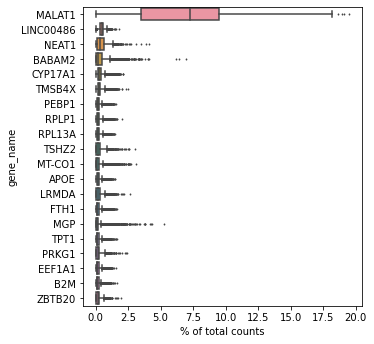

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

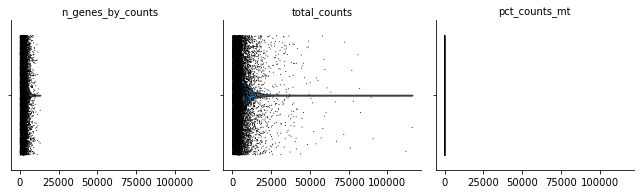

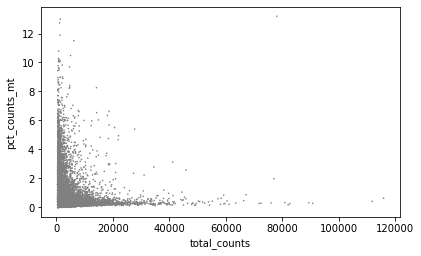

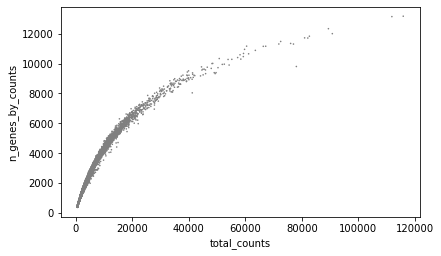

tenx solo rescue first phase QC


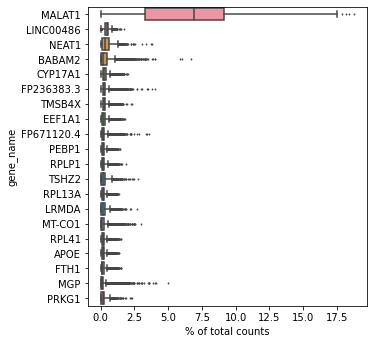

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

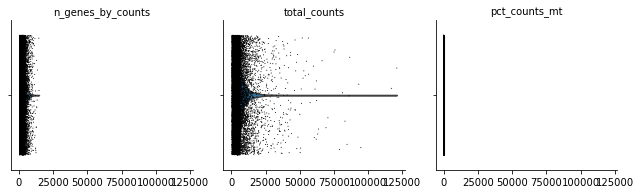

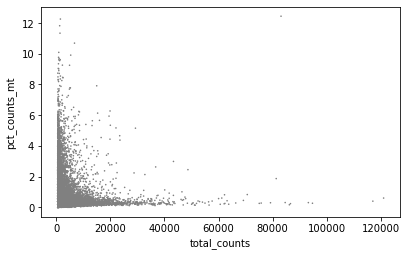

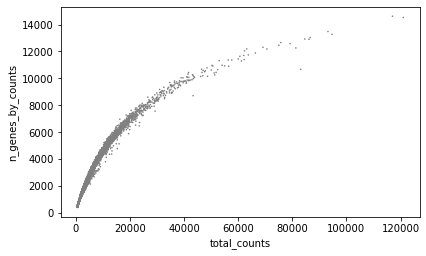

tenx solo em first phase QC


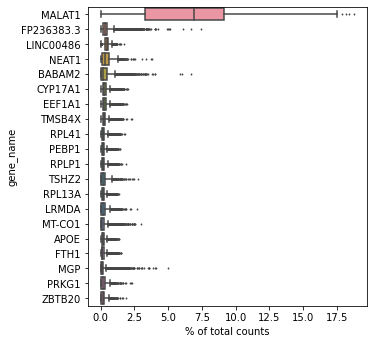

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

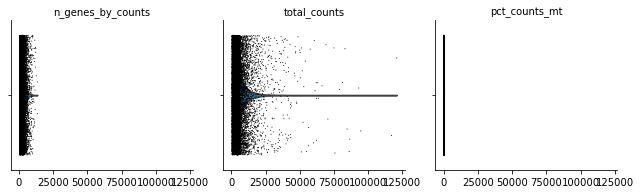

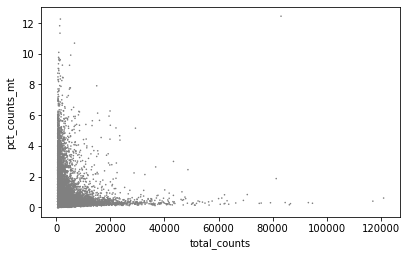

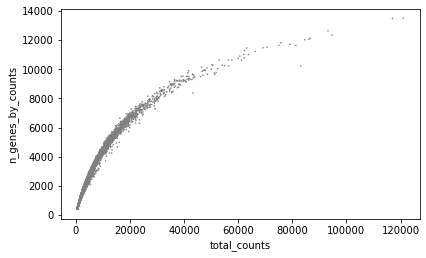

encode full solo uniq first phase QC


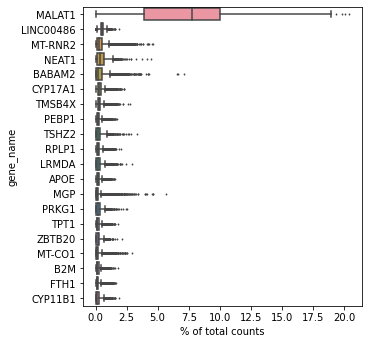

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

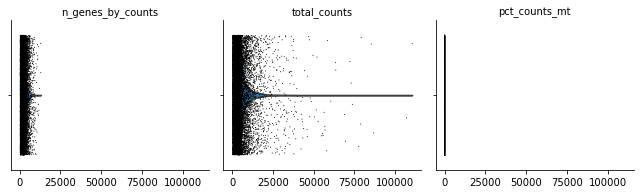

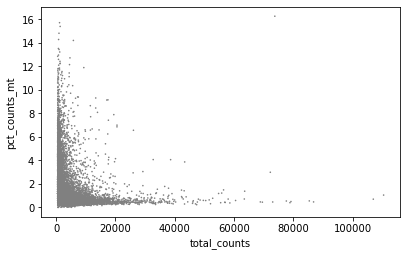

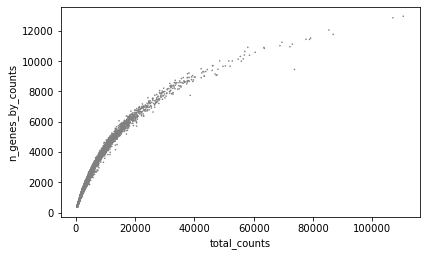

encode full solo rescue first phase QC


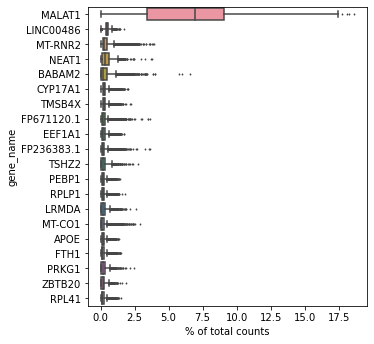

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

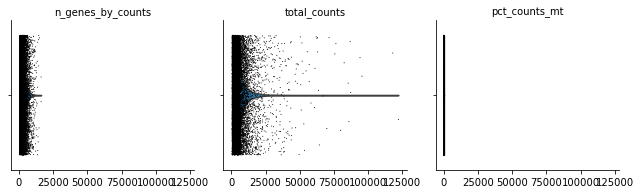

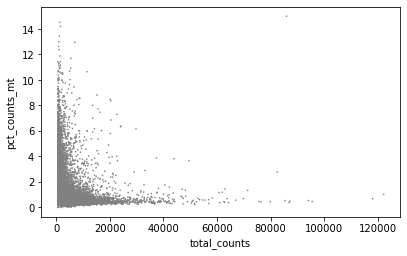

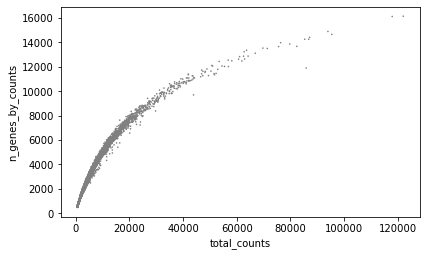

encode full solo em first phase QC


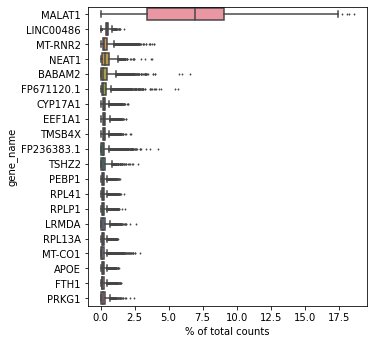

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

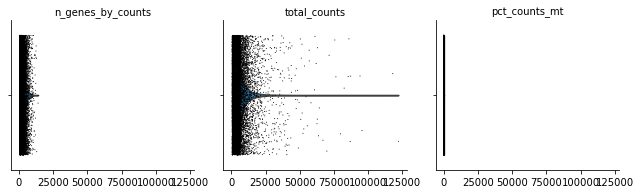

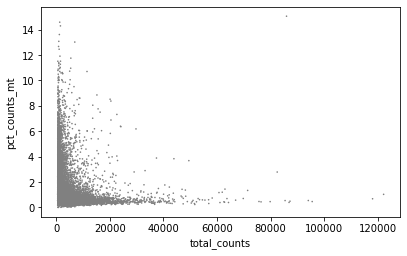

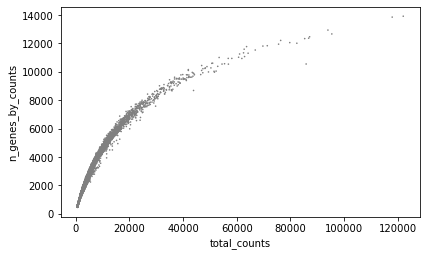

encode minimal solo uniq first phase QC


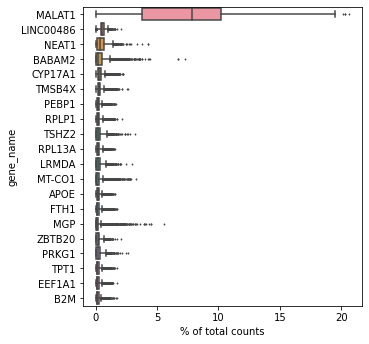

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

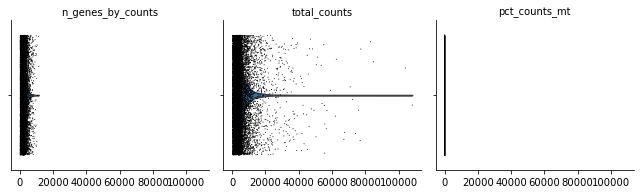

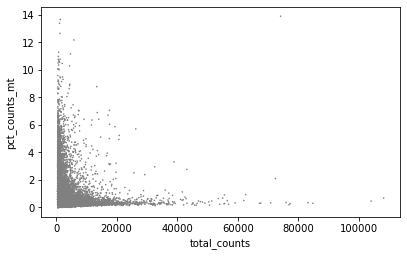

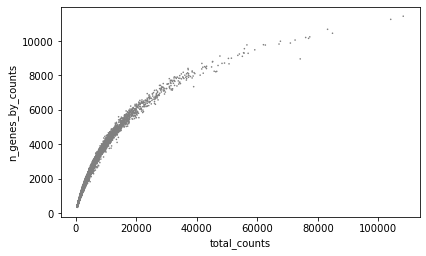

encode minimal solo rescue first phase QC


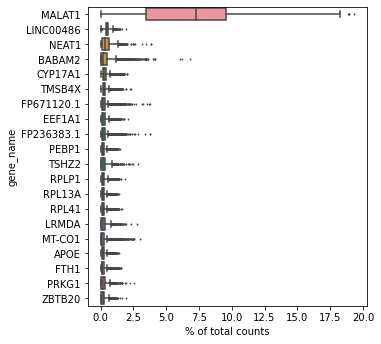

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

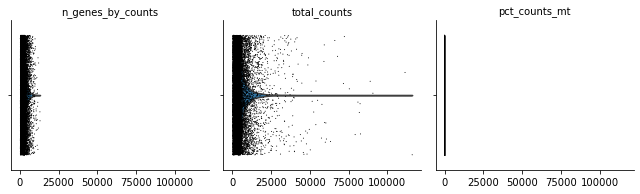

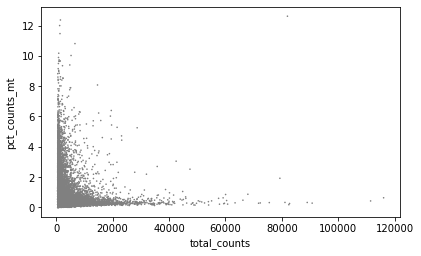

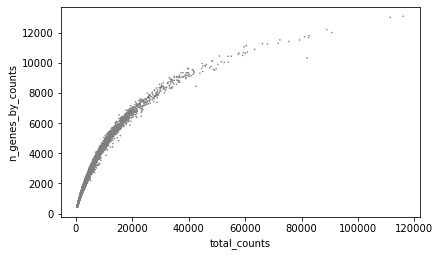

encode minimal solo em first phase QC


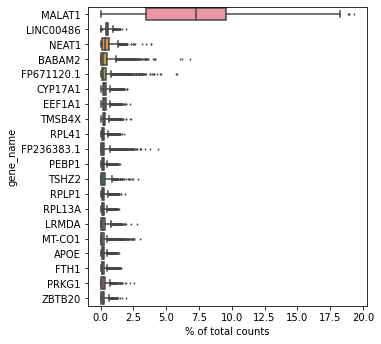

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

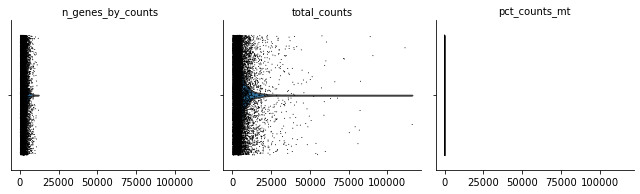

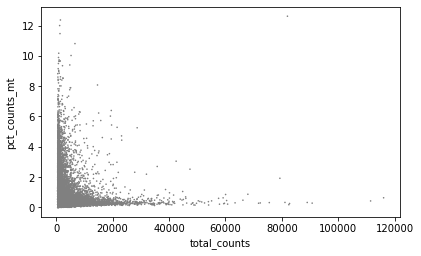

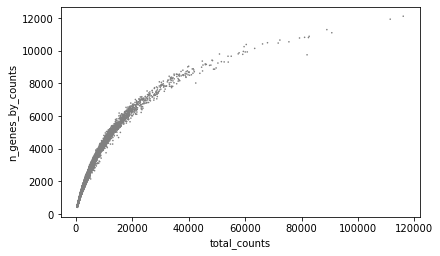

In [40]:
for algorithm in algorithm_filtered:
    print("{algorithm} first phase QC".format(algorithm=algorithm))    
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
    else:
        algorithm_filtered[algorithm].var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        
    scanpy.pl.highest_expr_genes(algorithm_filtered[algorithm], n_top=20, gene_symbols='gene_name')
    scanpy.pp.filter_cells(algorithm_filtered[algorithm], min_genes=200)
    scanpy.pp.filter_genes(algorithm_filtered[algorithm], min_cells=3)
    algorithm_filtered[algorithm].var['mt'] = algorithm_filtered[algorithm].var['gene_name'].str.startswith("MT-")
    scanpy.pp.calculate_qc_metrics(algorithm_filtered[algorithm], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    scanpy.pl.violin(
        algorithm_filtered[algorithm],
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, multi_panel=True)
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='pct_counts_mt')
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='n_genes_by_counts')        

tenx solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


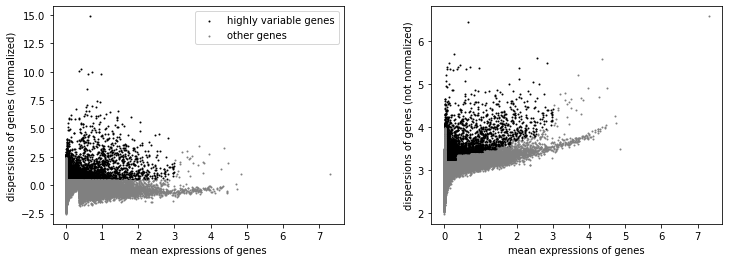

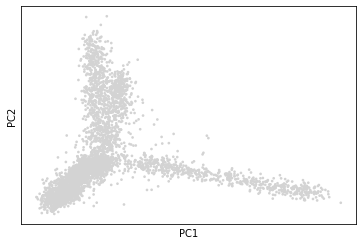

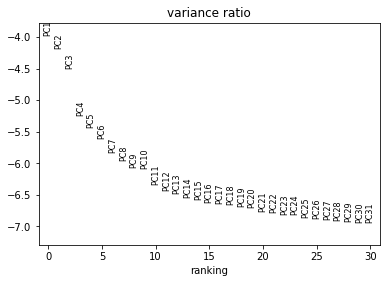

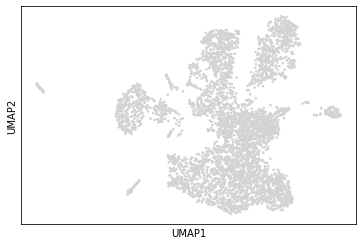

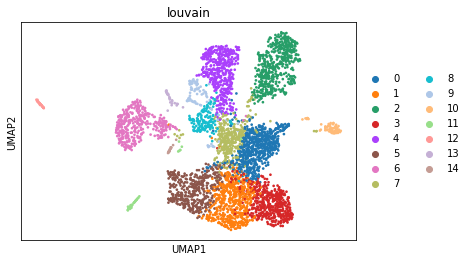

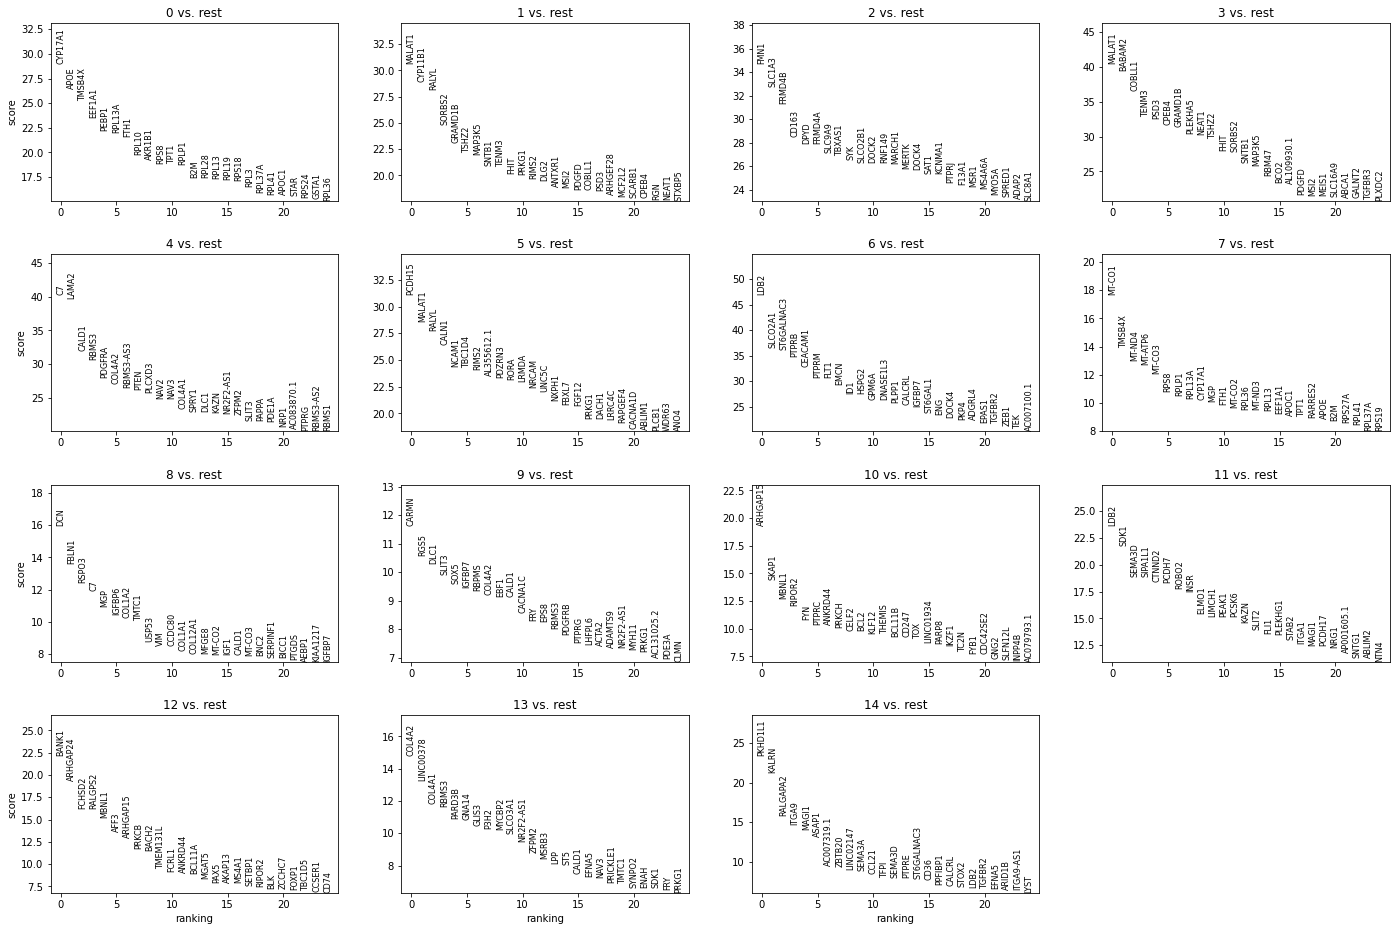

top gene names
         0        1       2       3       4       5           6        7  \
0  CYP17A1   MALAT1    FMN1  MALAT1      C7  PCDH15        LDB2   MT-CO1   
1     APOE  CYP11B1  SLC1A3  BABAM2   LAMA2  MALAT1     SLCO2A1   TMSB4X   
2   TMSB4X    RALYL  FRMD4B  COBLL1   CALD1   RALYL  ST6GALNAC3   MT-ND4   
3   EEF1A1   SORBS2   CD163   TENM3   RBMS3   CALN1       PTPRB  MT-ATP6   
4    PEBP1  GRAMD1B    DPYD    PSD3  PDGFRA   NCAM1     CEACAM1   MT-CO3   

       8      9        10       11        12         13        14  
0    DCN  CARMN  ARHGAP15     LDB2     BANK1     COL4A2   PKHD1L1  
1  FBLN1   RGS5     SKAP1     SDK1  ARHGAP24  LINC00378     KALRN  
2  RSPO3   DLC1     MBNL1   SEMA3D    FCHSD2     COL4A1  RALGAPA2  
3     C7  SLIT3    RIPOR2  SIPA1L1   RALGPS2      RBMS3     ITGA9  
4    MGP   SOX5       FYN   CTNND2     MBNL1     PARD3B     MAGI1  
tenx solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


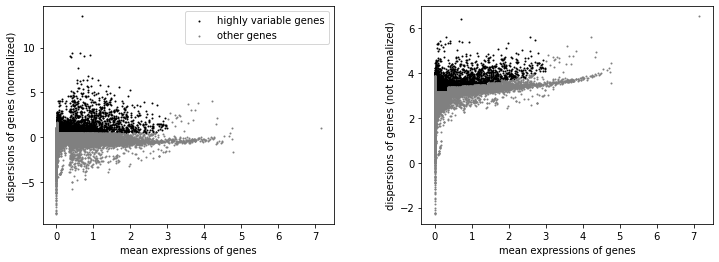

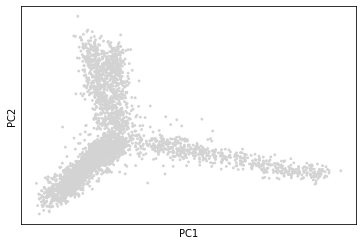

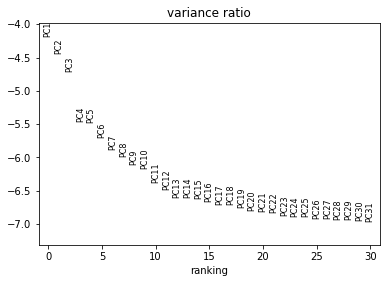

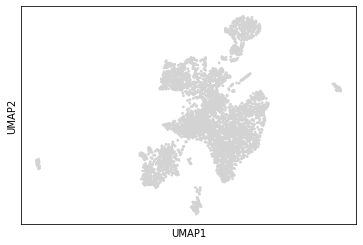

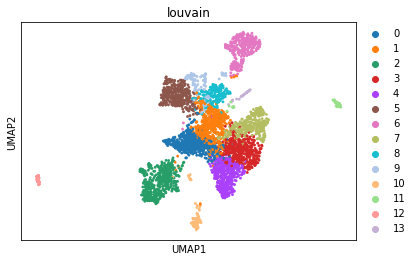

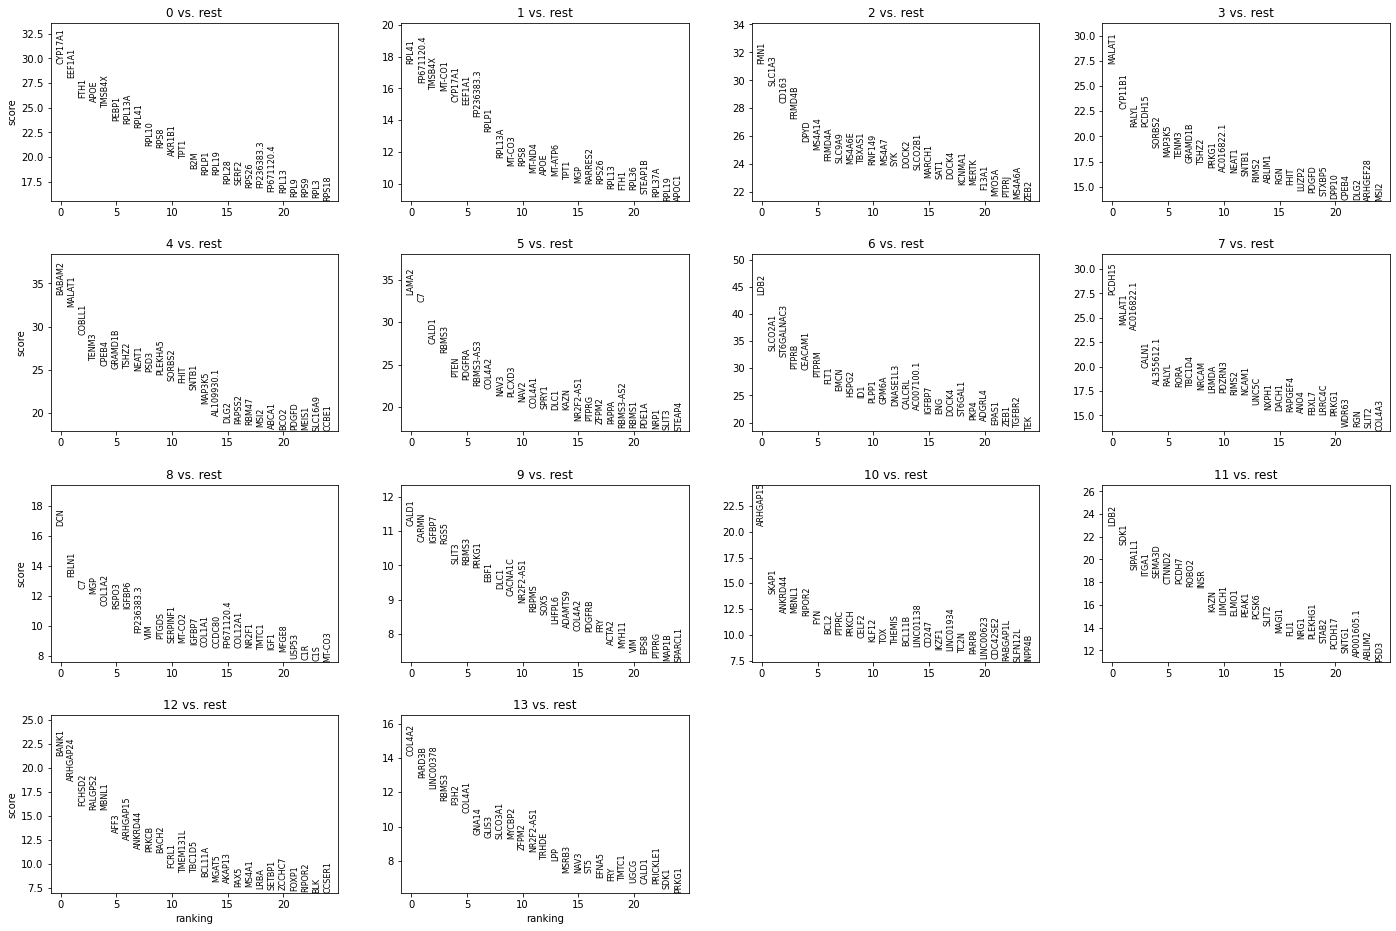

top gene names
         0           1       2        3       4      5           6  \
0  CYP17A1       RPL41    FMN1   MALAT1  BABAM2  LAMA2        LDB2   
1   EEF1A1  FP671120.1  SLC1A3  CYP11B1  MALAT1     C7     SLCO2A1   
2     FTH1      TMSB4X   CD163    RALYL  COBLL1  CALD1  ST6GALNAC3   
3     APOE      MT-CO1  FRMD4B   PCDH15   TENM3  RBMS3       PTPRB   
4   TMSB4X     CYP17A1    DPYD   SORBS2   CPEB4   PTEN     CEACAM1   

            7       8       9        10       11        12         13  
0      PCDH15     DCN   CALD1  ARHGAP15     LDB2     BANK1     COL4A2  
1      MALAT1   FBLN1   CARMN     SKAP1     SDK1  ARHGAP24     PARD3B  
2  AC016822.1      C7  IGFBP7   ANKRD44  SIPA1L1    FCHSD2  LINC00378  
3       CALN1     MGP    RGS5     MBNL1    ITGA1   RALGPS2      RBMS3  
4  AL590426.2  COL1A2   SLIT3    RIPOR2   SEMA3D     MBNL1       P3H2  
tenx solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


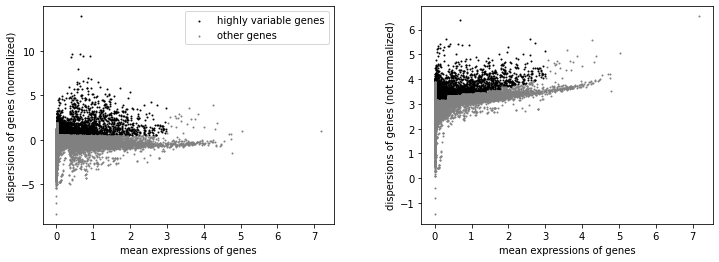

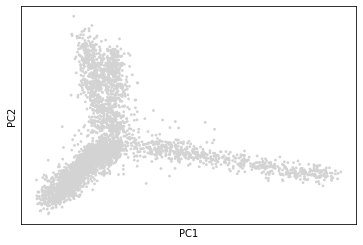

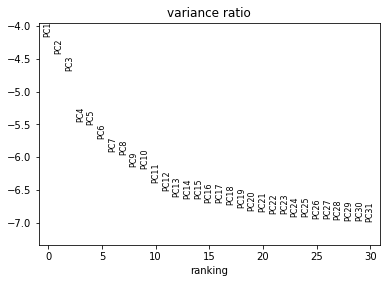

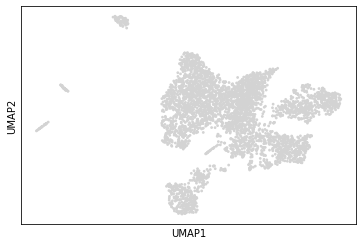

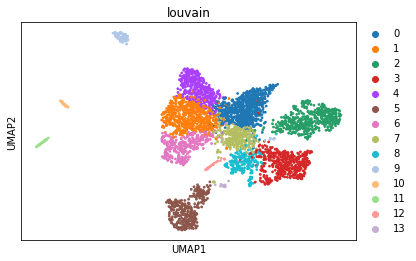

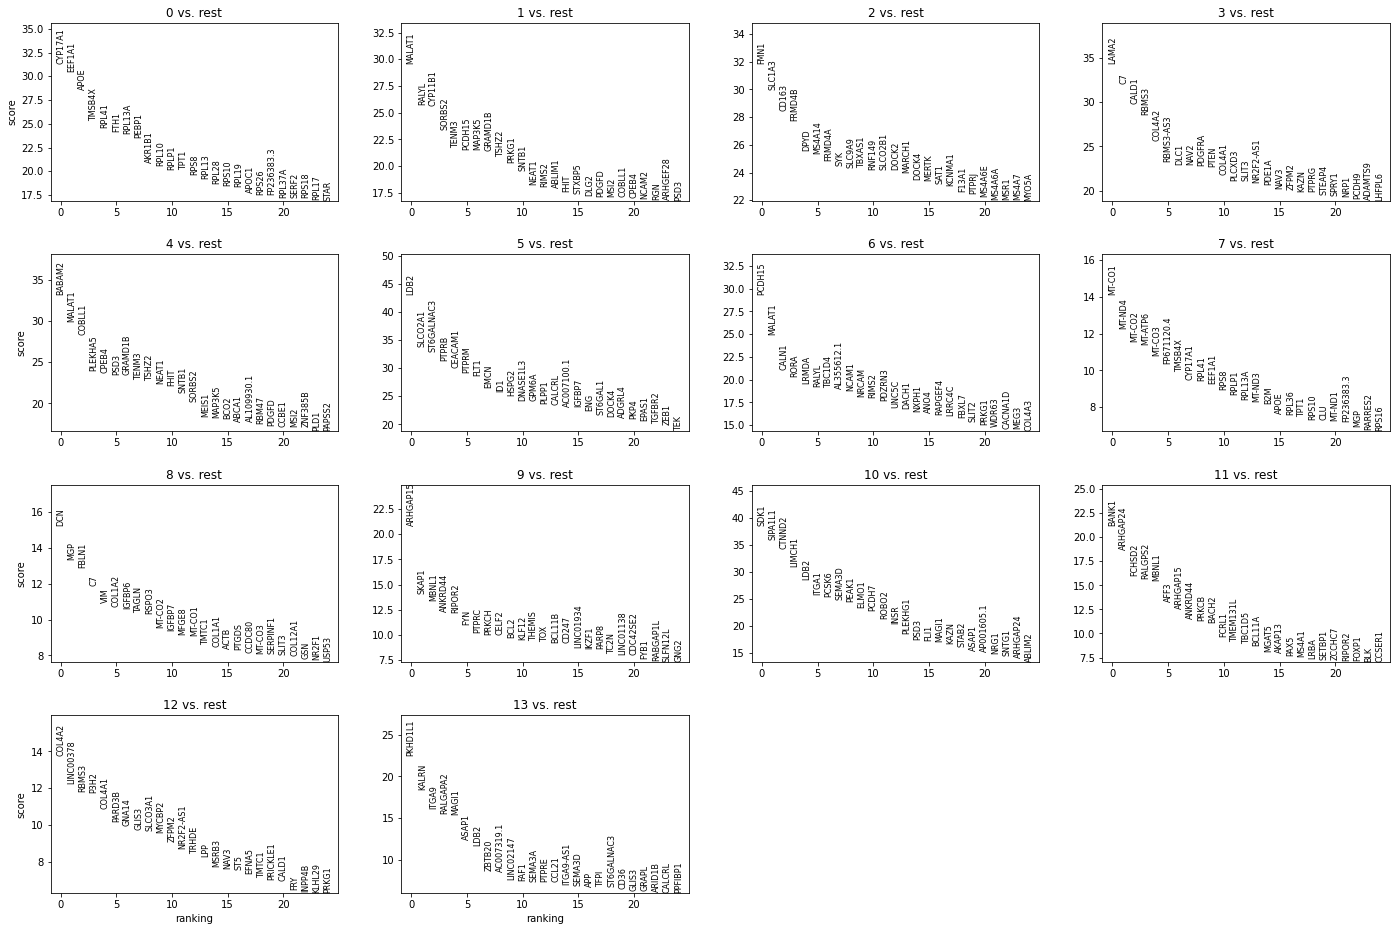

top gene names
         0        1       2       3        4           5       6        7  \
0  CYP17A1   MALAT1    FMN1   LAMA2   BABAM2        LDB2  PCDH15   MT-CO1   
1   EEF1A1    RALYL  SLC1A3      C7   MALAT1     SLCO2A1  MALAT1   MT-ND4   
2     APOE  CYP11B1   CD163   CALD1   COBLL1  ST6GALNAC3   CALN1   MT-CO2   
3   TMSB4X   SORBS2  FRMD4B   RBMS3  PLEKHA5       PTPRB    RORA  MT-ATP6   
4    RPL41    TENM3    DPYD  COL4A2    CPEB4     CEACAM1   LRMDA   MT-CO3   

       8         9       10        11         12        13  
0    DCN  ARHGAP15     SDK1     BANK1     COL4A2   PKHD1L1  
1    MGP     SKAP1  SIPA1L1  ARHGAP24  LINC00378     KALRN  
2  FBLN1     MBNL1   CTNND2    FCHSD2      RBMS3     ITGA9  
3     C7   ANKRD44   LIMCH1   RALGPS2       P3H2  RALGAPA2  
4    VIM    RIPOR2     LDB2     MBNL1     COL4A1     MAGI1  
encode full solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


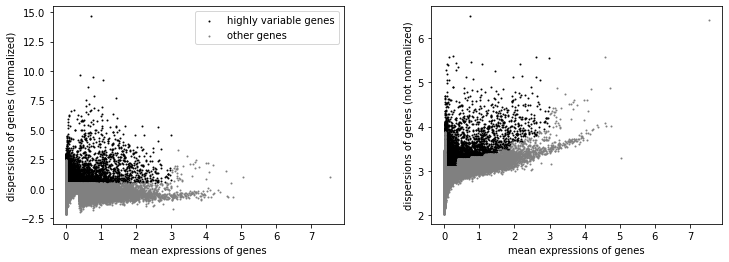

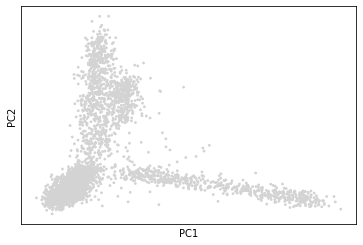

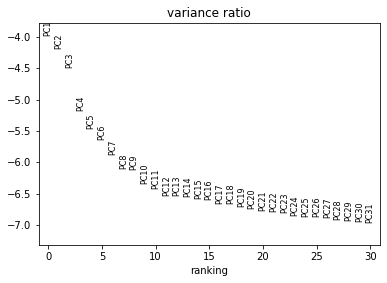

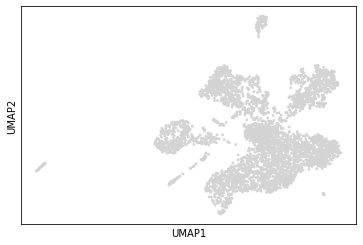

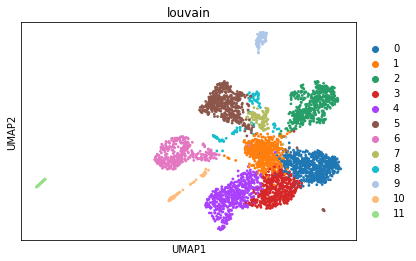

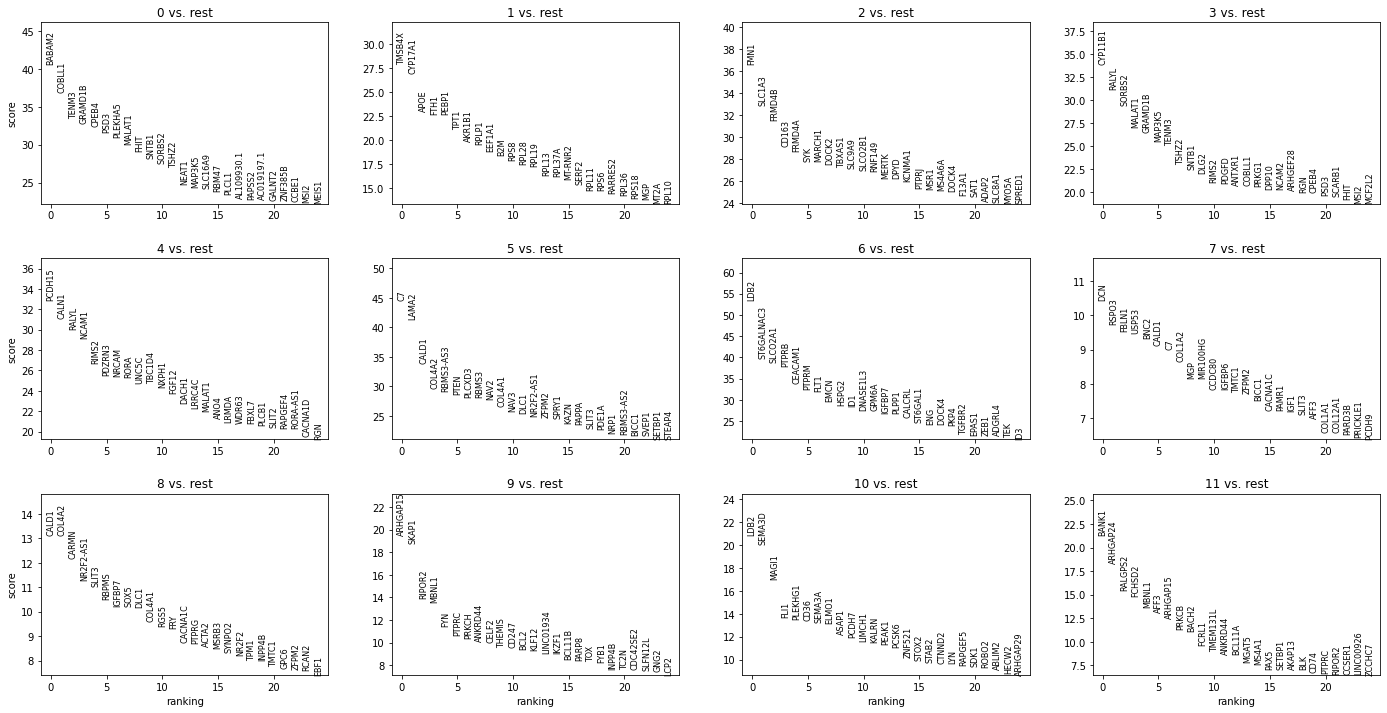

top gene names
         0        1       2        3       4          5           6      7  \
0   BABAM2   TMSB4X    FMN1  CYP11B1  PCDH15         C7        LDB2    DCN   
1   COBLL1  CYP17A1  SLC1A3    RALYL   CALN1      LAMA2  ST6GALNAC3  RSPO3   
2    TENM3     APOE  FRMD4B   SORBS2   RALYL      CALD1     SLCO2A1  FBLN1   
3  GRAMD1B     FTH1   CD163   MALAT1   NCAM1     COL4A2       PTPRB  USP53   
4    CPEB4    PEBP1  FRMD4A  GRAMD1B   RIMS2  RBMS3-AS3     CEACAM1   BNC2   

           8         9       10        11  
0      CALD1  ARHGAP15     LDB2     BANK1  
1     COL4A2     SKAP1   SEMA3D  ARHGAP24  
2      CARMN    RIPOR2    MAGI1   RALGPS2  
3  NR2F2-AS1     MBNL1     FLI1    FCHSD2  
4      SLIT3       FYN  PLEKHG1     MBNL1  
encode full solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


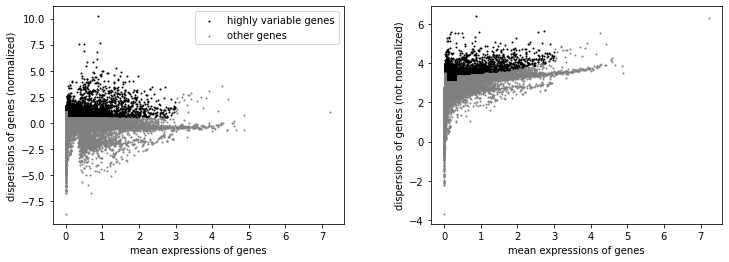

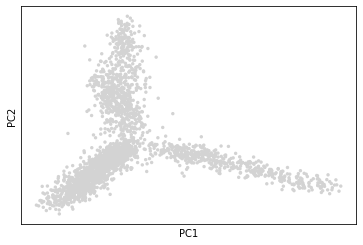

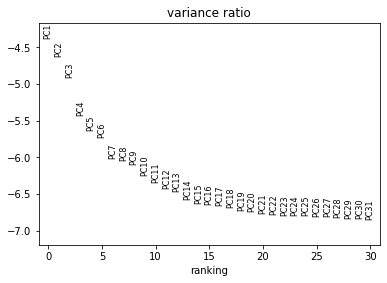

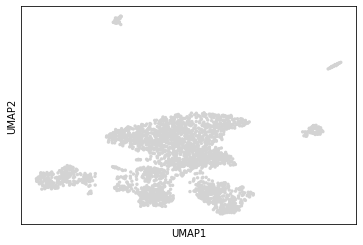

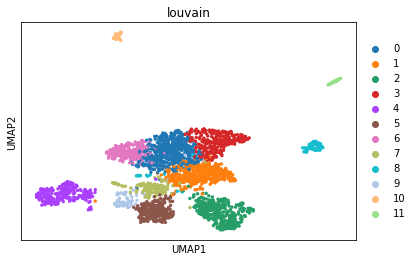

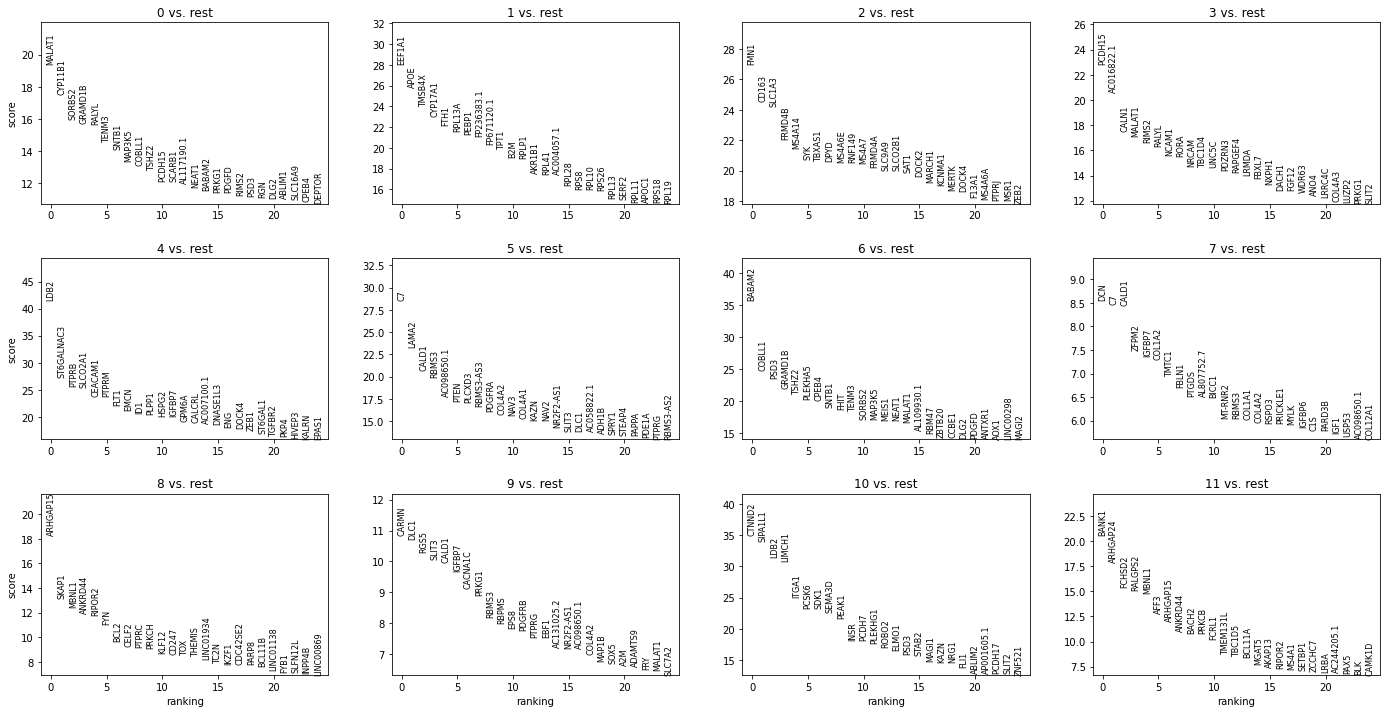

top gene names
         0        1       2           3           4           5        6  \
0   MALAT1   EEF1A1    FMN1      PCDH15        LDB2          C7   BABAM2   
1  CYP11B1     APOE   CD163  AC016822.1  ST6GALNAC3       LAMA2   COBLL1   
2   SORBS2   TMSB4X  SLC1A3       CALN1       PTPRB       CALD1     PSD3   
3  GRAMD1B  CYP17A1  FRMD4B      MALAT1     SLCO2A1       RBMS3  GRAMD1B   
4    RALYL     FTH1  MS4A14       RIMS2     CEACAM1  AC098650.1    TSHZ2   

        7         8      9       10        11  
0     DCN  ARHGAP15  CARMN   CTNND2     BANK1  
1      C7     SKAP1   DLC1  SIPA1L1  ARHGAP24  
2   CALD1     MBNL1   RGS5     LDB2    FCHSD2  
3   ZFPM2   ANKRD44  SLIT3   LIMCH1   RALGPS2  
4  IGFBP7    RIPOR2  CALD1    ITGA1     MBNL1  
encode full solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


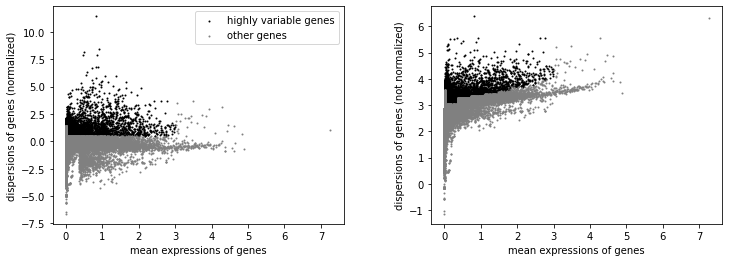

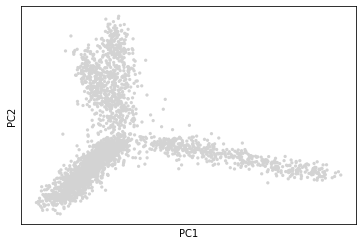

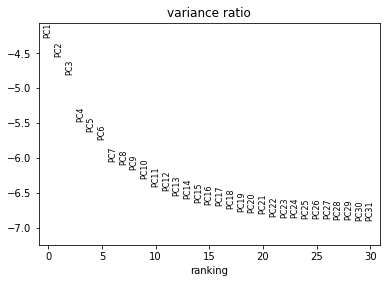

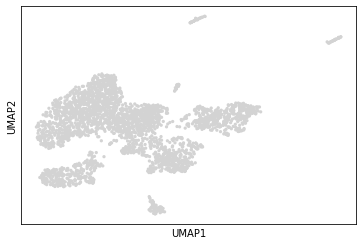

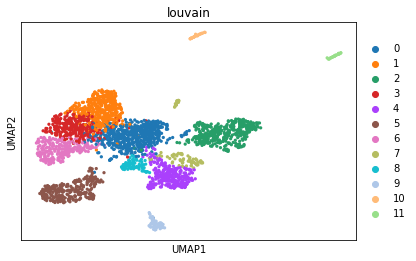

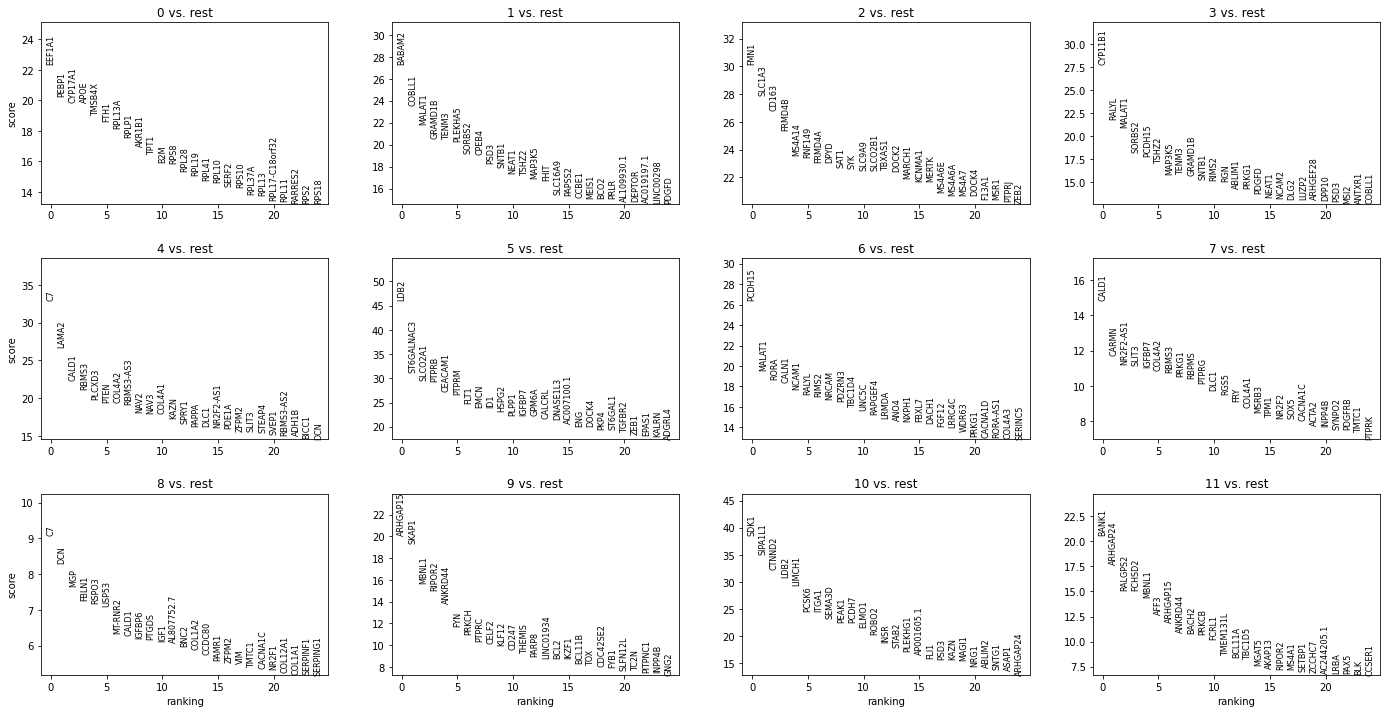

top gene names
         0        1       2        3       4           5       6          7  \
0   EEF1A1   BABAM2    FMN1  CYP11B1      C7        LDB2  PCDH15      CALD1   
1    PEBP1   COBLL1  SLC1A3    RALYL   LAMA2  ST6GALNAC3  MALAT1      CARMN   
2  CYP17A1   MALAT1   CD163   MALAT1   CALD1     SLCO2A1    RORA  NR2F2-AS1   
3     APOE  GRAMD1B  FRMD4B   SORBS2   RBMS3       PTPRB   CALN1      SLIT3   
4   TMSB4X    TENM3  MS4A14   PCDH15  PLCXD3     CEACAM1   NCAM1     IGFBP7   

       8         9       10        11  
0     C7  ARHGAP15     SDK1     BANK1  
1    DCN     SKAP1  SIPA1L1  ARHGAP24  
2    MGP     MBNL1   CTNND2   RALGPS2  
3  FBLN1    RIPOR2     LDB2    FCHSD2  
4  RSPO3   ANKRD44   LIMCH1     MBNL1  
encode minimal solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


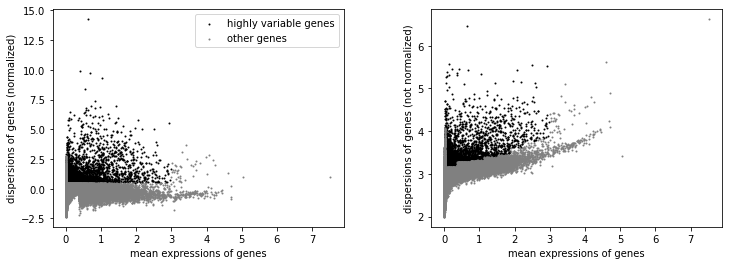

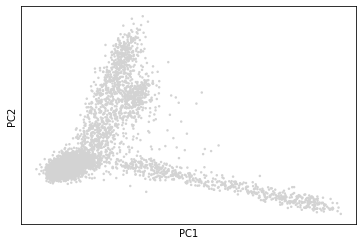

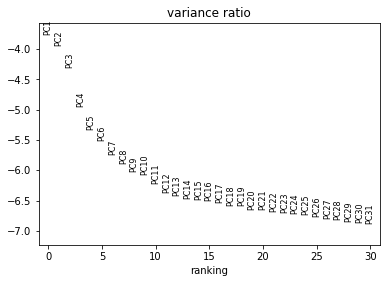

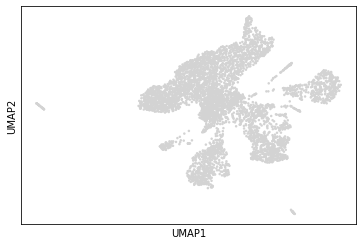

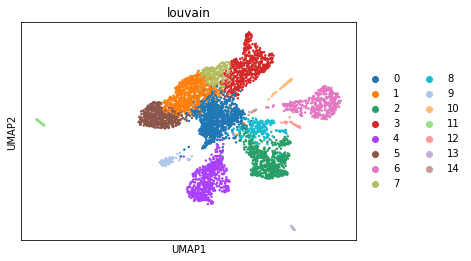

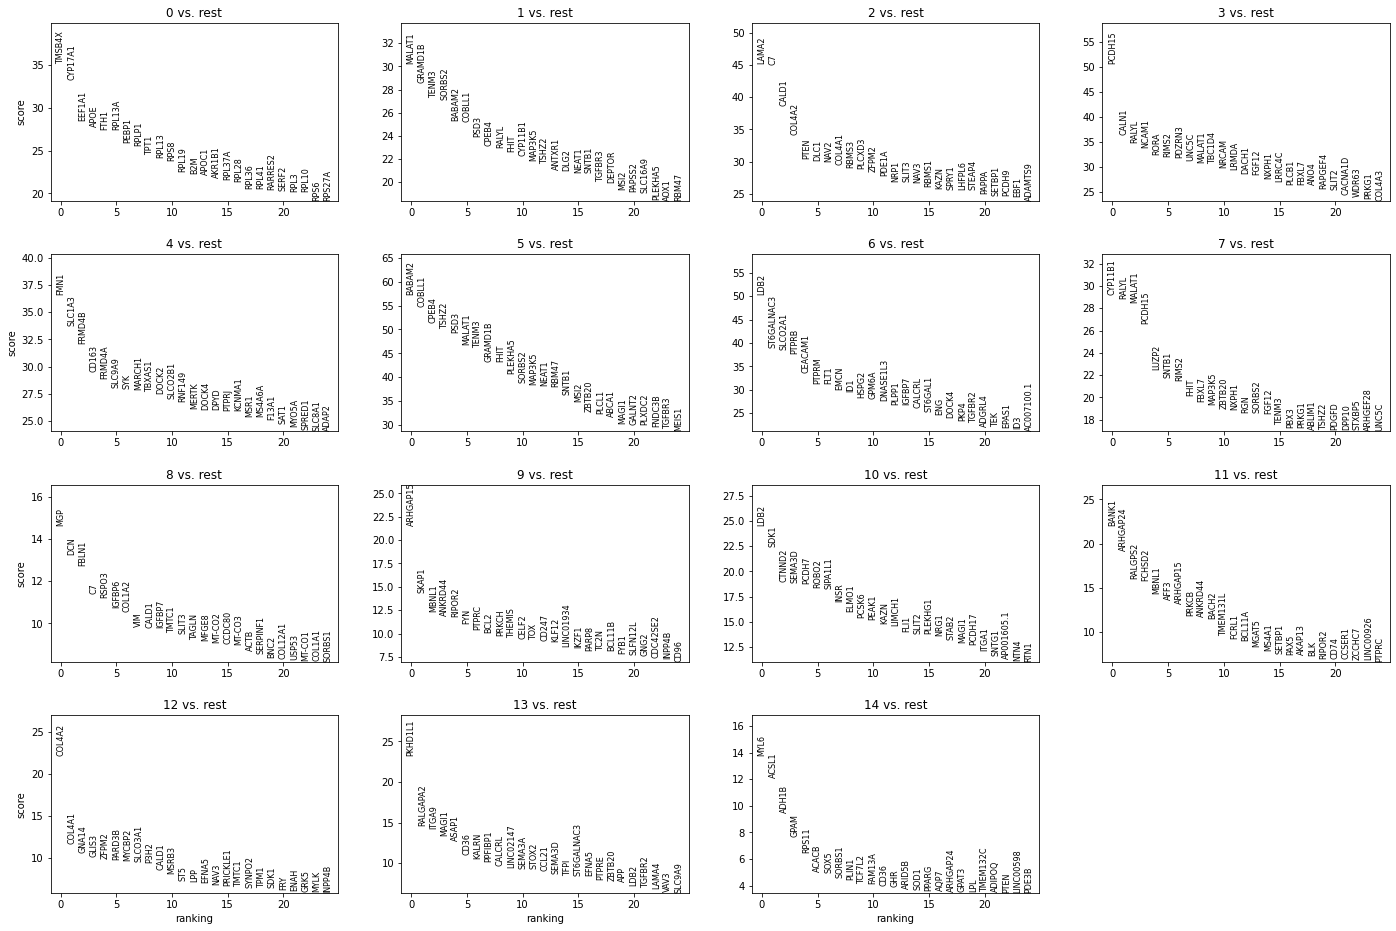

top gene names
         0        1       2       3       4       5           6        7  \
0   TMSB4X   MALAT1   LAMA2  PCDH15    FMN1  BABAM2        LDB2  CYP11B1   
1  CYP17A1  GRAMD1B      C7   CALN1  SLC1A3  COBLL1  ST6GALNAC3    RALYL   
2   EEF1A1    TENM3   CALD1   RALYL  FRMD4B   CPEB4     SLCO2A1   MALAT1   
3     APOE   SORBS2  COL4A2   NCAM1   CD163   TSHZ2       PTPRB   PCDH15   
4     FTH1   BABAM2    PTEN    RORA  FRMD4A    PSD3     CEACAM1    LUZP2   

       8         9      10        11      12        13     14  
0    MGP  ARHGAP15    LDB2     BANK1  COL4A2   PKHD1L1   MYL6  
1    DCN     SKAP1    SDK1  ARHGAP24  COL4A1  RALGAPA2  ACSL1  
2  FBLN1     MBNL1  CTNND2   RALGPS2   GNA14     ITGA9  ADH1B  
3     C7   ANKRD44  SEMA3D    FCHSD2   GLIS3     MAGI1   GPAM  
4  RSPO3    RIPOR2   PCDH7     MBNL1   ZFPM2     ASAP1  RPS11  
encode minimal solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


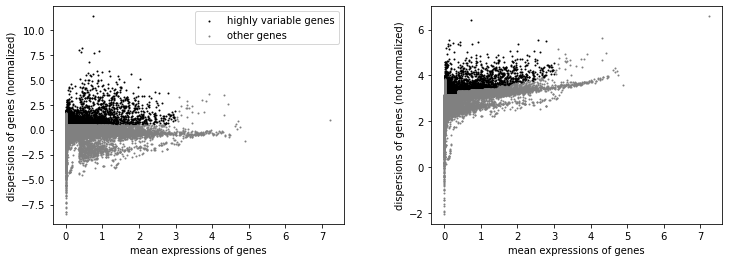

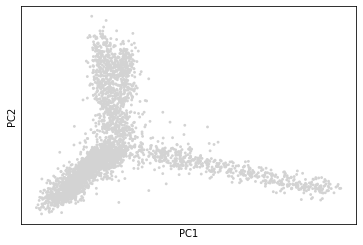

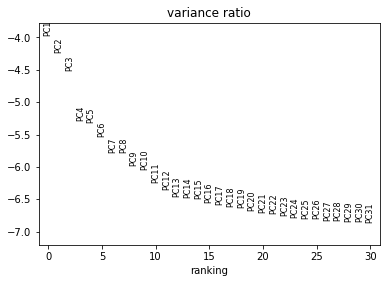

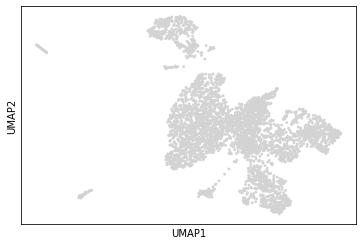

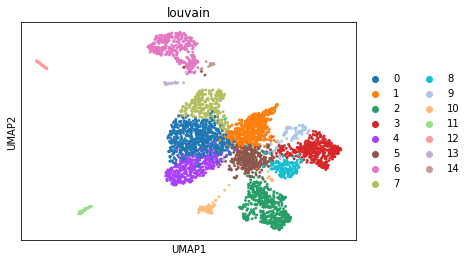

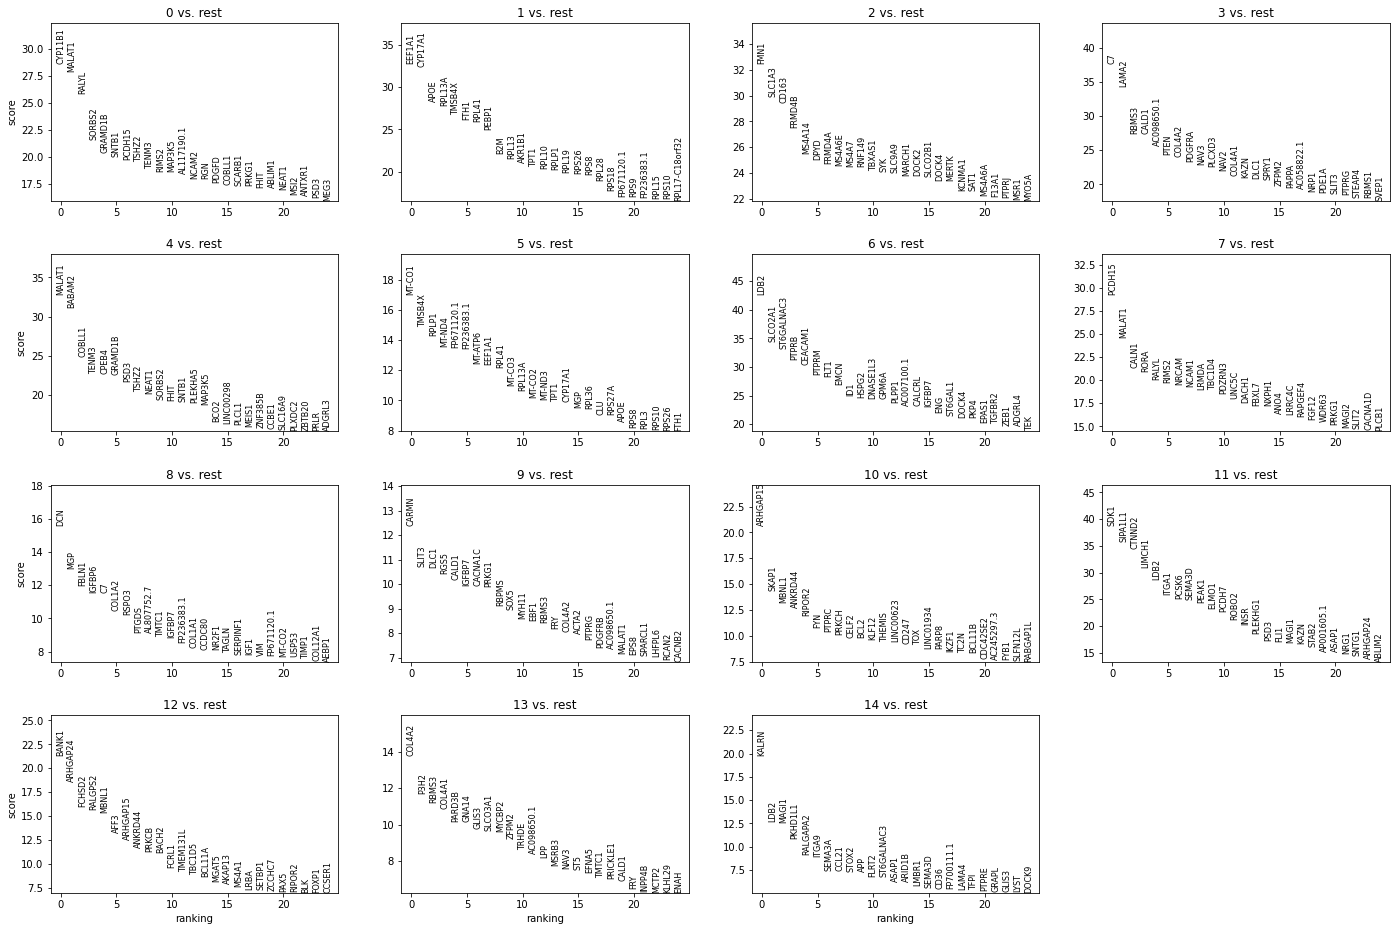

top gene names
         0        1       2           3       4           5           6  \
0  CYP11B1   EEF1A1    FMN1          C7  MALAT1      MT-CO1        LDB2   
1   MALAT1  CYP17A1  SLC1A3       LAMA2  BABAM2      TMSB4X     SLCO2A1   
2    RALYL     APOE   CD163       RBMS3  COBLL1       RPLP1  ST6GALNAC3   
3   SORBS2   RPL13A  FRMD4B       CALD1   TENM3      MT-ND4       PTPRB   
4  GRAMD1B   TMSB4X  MS4A14  AC098650.1   CPEB4  FP671120.1     CEACAM1   

        7       8      9        10       11        12      13        14  
0  PCDH15     DCN  CARMN  ARHGAP15     SDK1     BANK1  COL4A2     KALRN  
1  MALAT1     MGP  SLIT3     SKAP1  SIPA1L1  ARHGAP24    P3H2      LDB2  
2   CALN1   FBLN1   DLC1     MBNL1   CTNND2    FCHSD2   RBMS3     MAGI1  
3    RORA  IGFBP6   RGS5   ANKRD44   LIMCH1   RALGPS2  COL4A1   PKHD1L1  
4   RALYL      C7  CALD1    RIPOR2     LDB2     MBNL1  PARD3B  RALGAPA2  
encode minimal solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


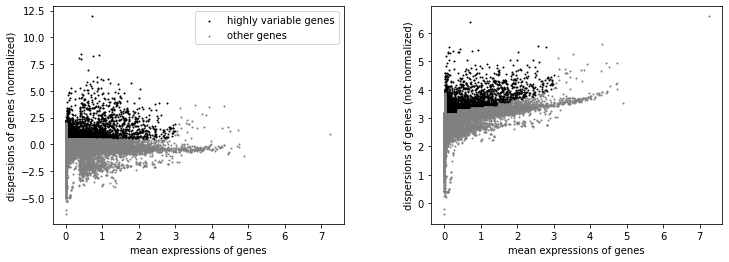

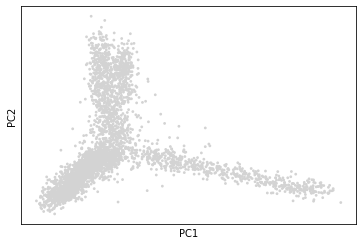

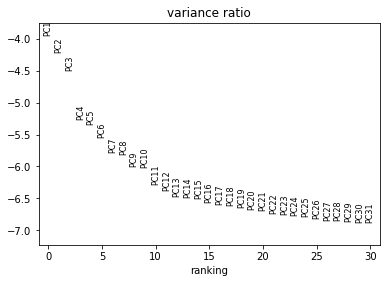

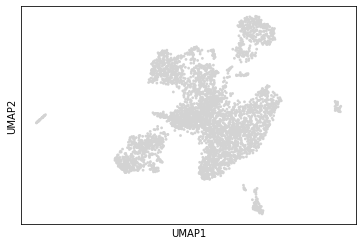

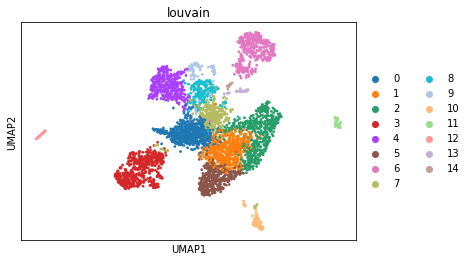

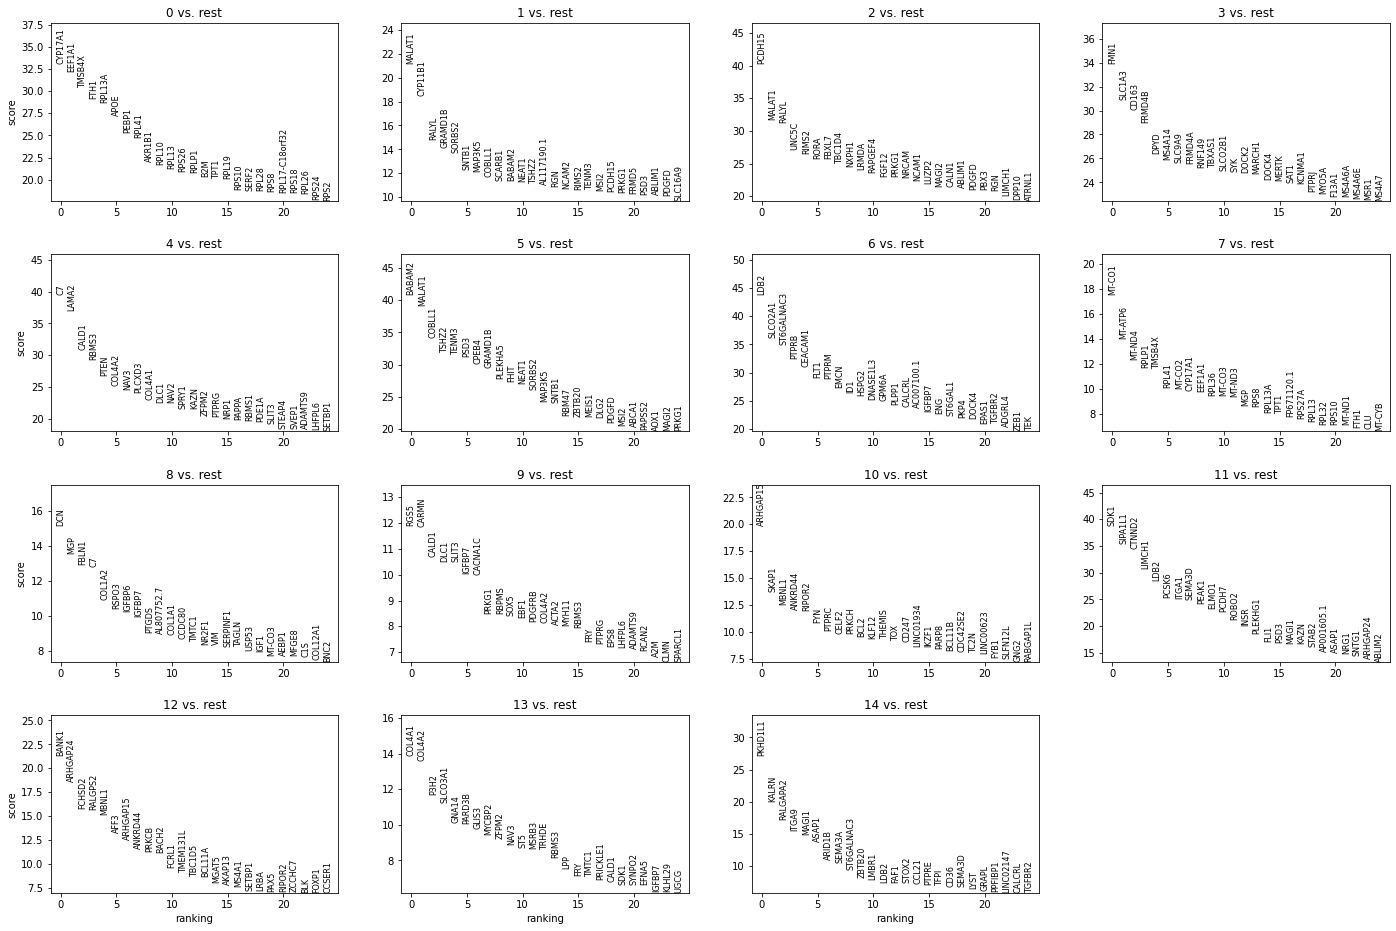

top gene names
         0        1       2       3      4       5           6        7  \
0  CYP17A1   MALAT1  PCDH15    FMN1     C7  BABAM2        LDB2   MT-CO1   
1   EEF1A1  CYP11B1  MALAT1  SLC1A3  LAMA2  MALAT1     SLCO2A1  MT-ATP6   
2   TMSB4X    RALYL   RALYL   CD163  CALD1  COBLL1  ST6GALNAC3   MT-ND4   
3     FTH1  GRAMD1B   UNC5C  FRMD4B  RBMS3   TSHZ2       PTPRB    RPLP1   
4   RPL13A   SORBS2   RIMS2    DPYD   PTEN   TENM3     CEACAM1   TMSB4X   

        8      9        10       11        12       13        14  
0     DCN   RGS5  ARHGAP15     SDK1     BANK1   COL4A1   PKHD1L1  
1     MGP  CARMN     SKAP1  SIPA1L1  ARHGAP24   COL4A2     KALRN  
2   FBLN1  CALD1     MBNL1   CTNND2    FCHSD2     P3H2  RALGAPA2  
3      C7   DLC1   ANKRD44   LIMCH1   RALGPS2  SLCO3A1     ITGA9  
4  COL1A2  SLIT3    RIPOR2     LDB2     MBNL1    GNA14     MAGI1  


In [41]:
algorithm_scanpy_filtered = {}
algorithm_top_gene_ids = {}
algorithm_top_gene_names = {}
for algorithm in algorithm_filtered:
    #print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
    print("{algorithm} clustering".format(algorithm=algorithm))
    algorithm_scanpy_filtered[algorithm] = algorithm_filtered[algorithm][algorithm_filtered[algorithm].obs.n_genes_by_counts < 2000, :]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][algorithm_scanpy_filtered[algorithm].obs.pct_counts_mt < 2.5, :]
    
    scanpy.pp.normalize_total(algorithm_scanpy_filtered[algorithm], target_sum=30000)
    scanpy.pp.log1p(algorithm_scanpy_filtered[algorithm])
    scanpy.pp.highly_variable_genes(algorithm_scanpy_filtered[algorithm], min_mean=0.0125, max_mean=3, min_disp=0.5)
    scanpy.pl.highly_variable_genes(algorithm_scanpy_filtered[algorithm])
    algorithm_scanpy_filtered[algorithm].raw = algorithm_scanpy_filtered[algorithm]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][:, algorithm_scanpy_filtered[algorithm].var.highly_variable]
   
    scanpy.pp.regress_out( algorithm_scanpy_filtered[algorithm], ['total_counts', 'pct_counts_mt'])
    scanpy.pp.scale( algorithm_scanpy_filtered[algorithm], max_value=10)
    scanpy.tl.pca(algorithm_scanpy_filtered[algorithm], svd_solver='arpack')
    scanpy.pl.pca(algorithm_scanpy_filtered[algorithm])

    scanpy.pl.pca_variance_ratio(algorithm_scanpy_filtered[algorithm], log=True)
    
    scanpy.pp.neighbors(algorithm_scanpy_filtered[algorithm], n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm])
    
    scanpy.tl.louvain(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm], color=['louvain'])
    
    scanpy.tl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], 'louvain', method='t-test')
    scanpy.pl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], n_genes=25, sharey=False, gene_symbols='gene_name')
    
    algorithm_top_gene_ids[algorithm] = pandas.DataFrame(algorithm_scanpy_filtered[algorithm].uns['rank_genes_groups']['names'])    
    if algorithm == "tenx solo uniq":
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v32m_gene_id_to_name.get(x, x))
    else:
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v29_gene_id_to_name.get(x, x))
    print('top gene names')
    print(algorithm_top_gene_names[algorithm].head(5))

# Cell barcodes left in common after scanpy filtering

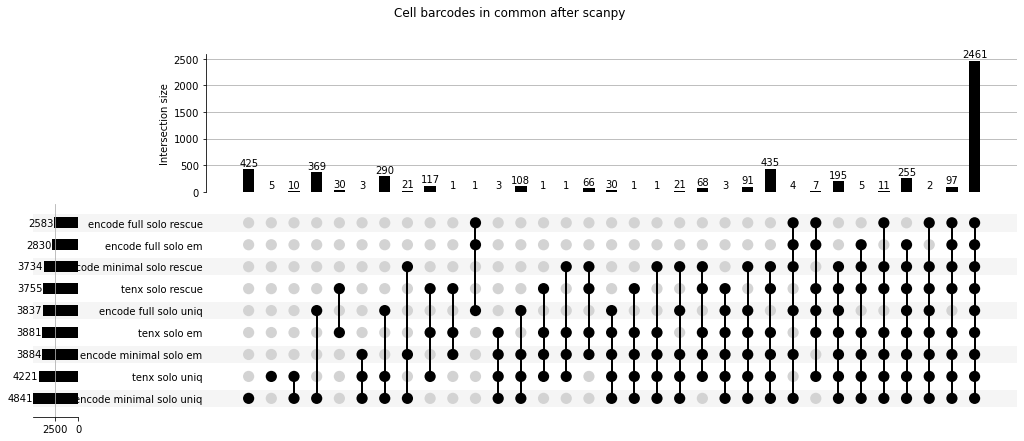

In [42]:
tutoral_barcode_set = upsetplot.from_contents({
    k: algorithm_scanpy_filtered[k].obs_names for k in algorithm_scanpy_filtered
})
f = pyplot.figure()
f.suptitle("Cell barcodes in common after scanpy")
_ = upsetplot.plot(tutoral_barcode_set, show_counts=True, fig=f)


# Gene IDs in common after scanpy filtering

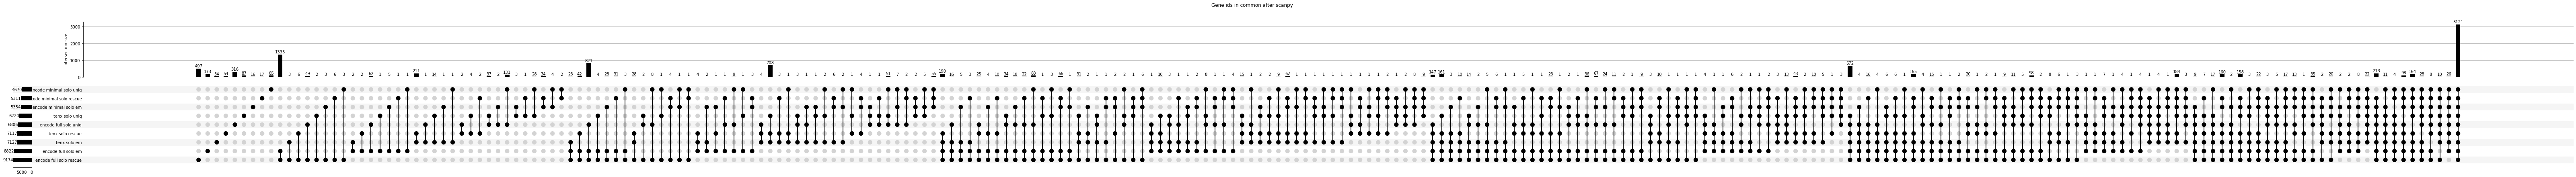

In [43]:
common_filtered_gene_base_contents = {}
for algorithm in algorithm_scanpy_filtered:
    #if algorithm == 'tenx solo uniq':
    #    common_filtered_gene_base_contents[algorithm] = {gene_id for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    #else:
    #common_filtered_gene_base_contents[algorithm] = {gene_id.split('.')[0] for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    common_filtered_gene_base_contents[algorithm] = set(algorithm_scanpy_filtered[algorithm].var_names)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents(common_filtered_gene_base_contents)

f = pyplot.figure()
f.suptitle("Gene ids in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [44]:
common_filtered_gene_base_set

id
tenx solo uniq tenx solo rescue tenx solo em encode full solo uniq encode full solo rescue encode full solo em encode minimal solo uniq encode minimal solo rescue encode minimal solo em                    
True           True             True         True                  True                    True                True                     True                       True                    ENSG00000144668.11
                                                                                                                                                                   True                     ENSG00000124257.6
                                                                                                                                                                   True                    ENSG00000143797.11
                                             False                 False                   False               False                    False                      False                      ENSG00000287338
                                             True                  True                    True                True                     True                       True                    ENSG00000125355.15
...                                                                                                                                                                                                       ...
False          False            False        False                 False                   False               False                    False                      True                    ENSG00000167333.12
                                                                                                                                                                   True                     ENSG00000285841.1
                                                                                                                                                                   True                    ENSG00000162734.12
                                                                                                                                                                   True                     ENSG00000253184.1
                                                                                                                                                                   True                     ENSG00000179859.9

[11914 rows x 1 columns]

In [45]:
#common_filtered_gene_base_set.loc[True, False, True]['id']

In [46]:
#v29_gtf.set_index('gene_id').reindex(common_filtered_gene_base_set.loc[True, False, True]['id'])

In [47]:
def build_confusion_matrix(left, right, N=20):
    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

# Confusion matrices between top N genes in each cluster

In [48]:
def plot_algorithm_confusion(table, programs=None, N=20):
    if programs is None:
        programs = list(table.keys())
    confusion = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            cm = build_confusion_matrix(table[name_x], table[name_y], N)
            seaborn.heatmap(cm, annot=False, ax=ax)
            
            if x == 0:
                ax.set_ylabel(name_y)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Gene name confusion matrix of top {} genes".format(N))
    #f.tight_layout()


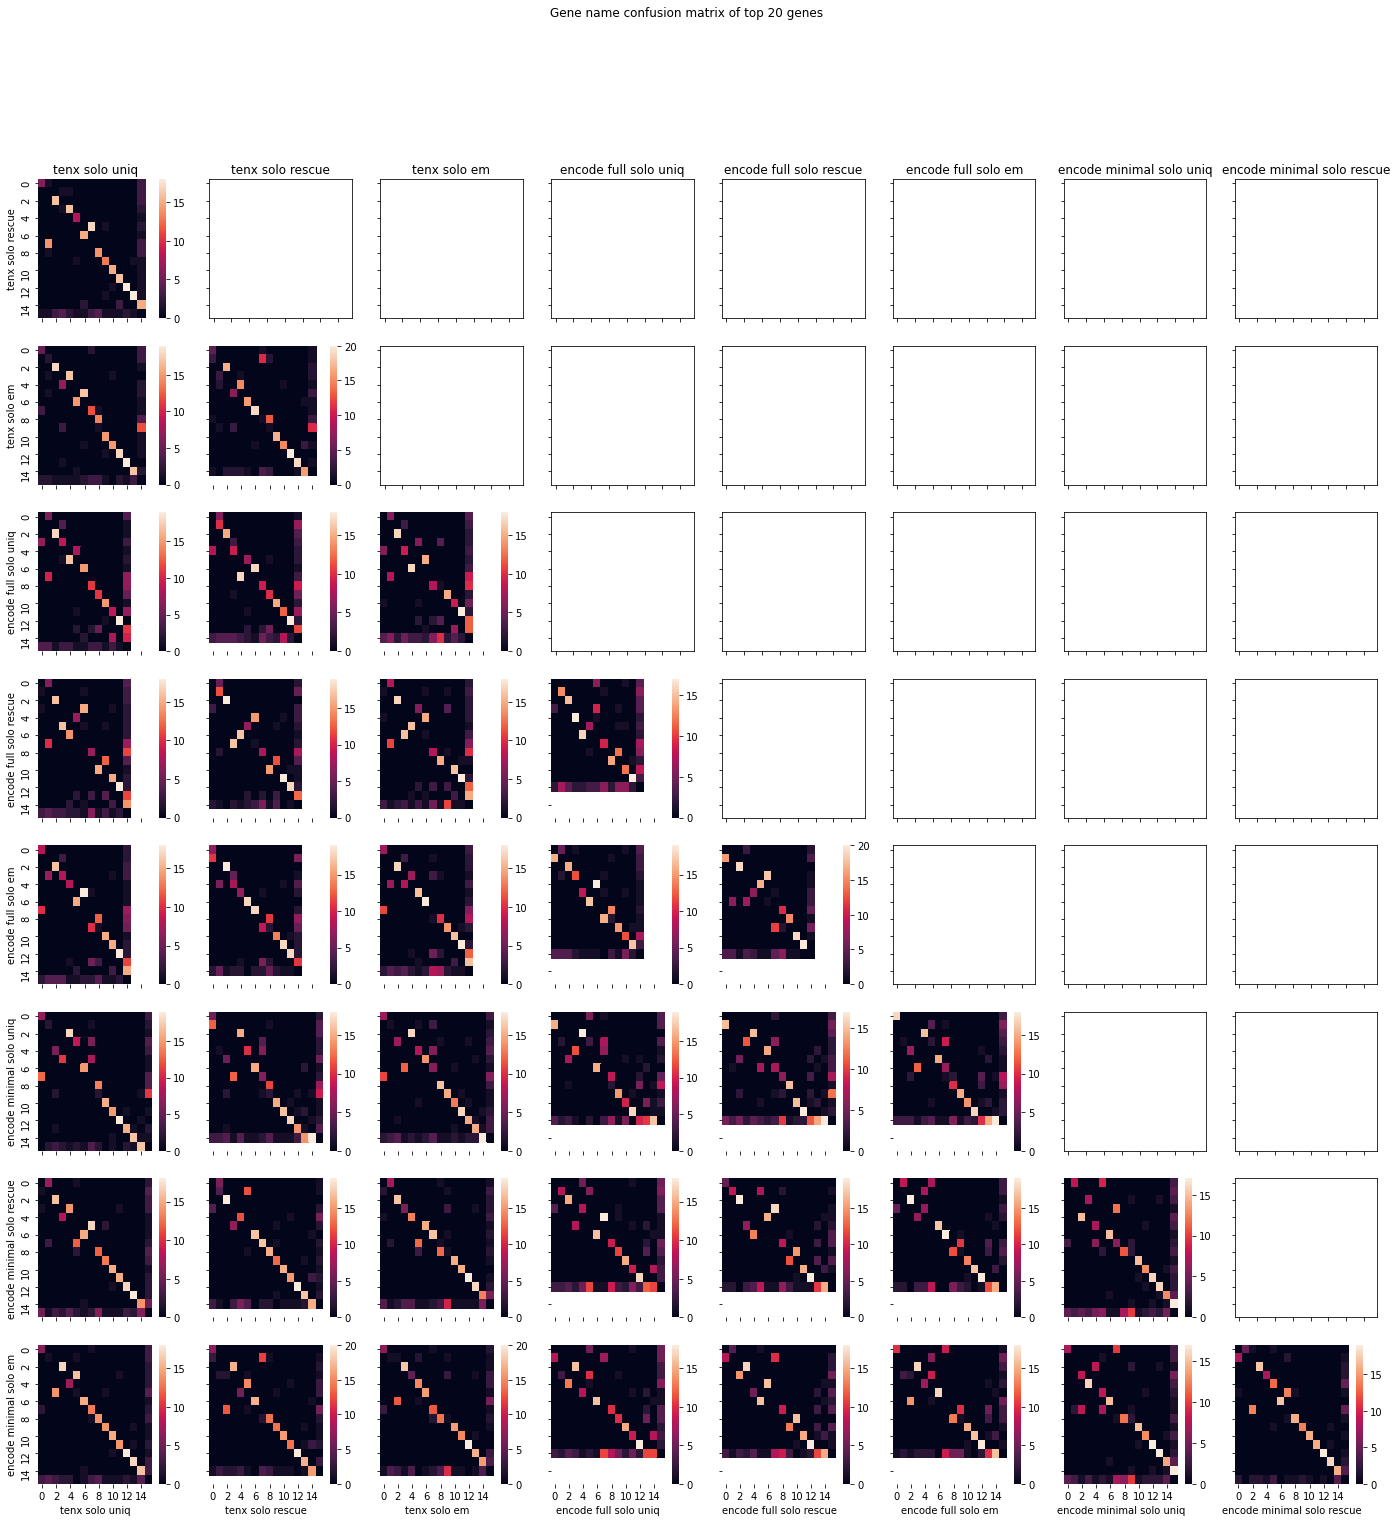

In [49]:
plot_algorithm_confusion(algorithm_top_gene_names, N=20)

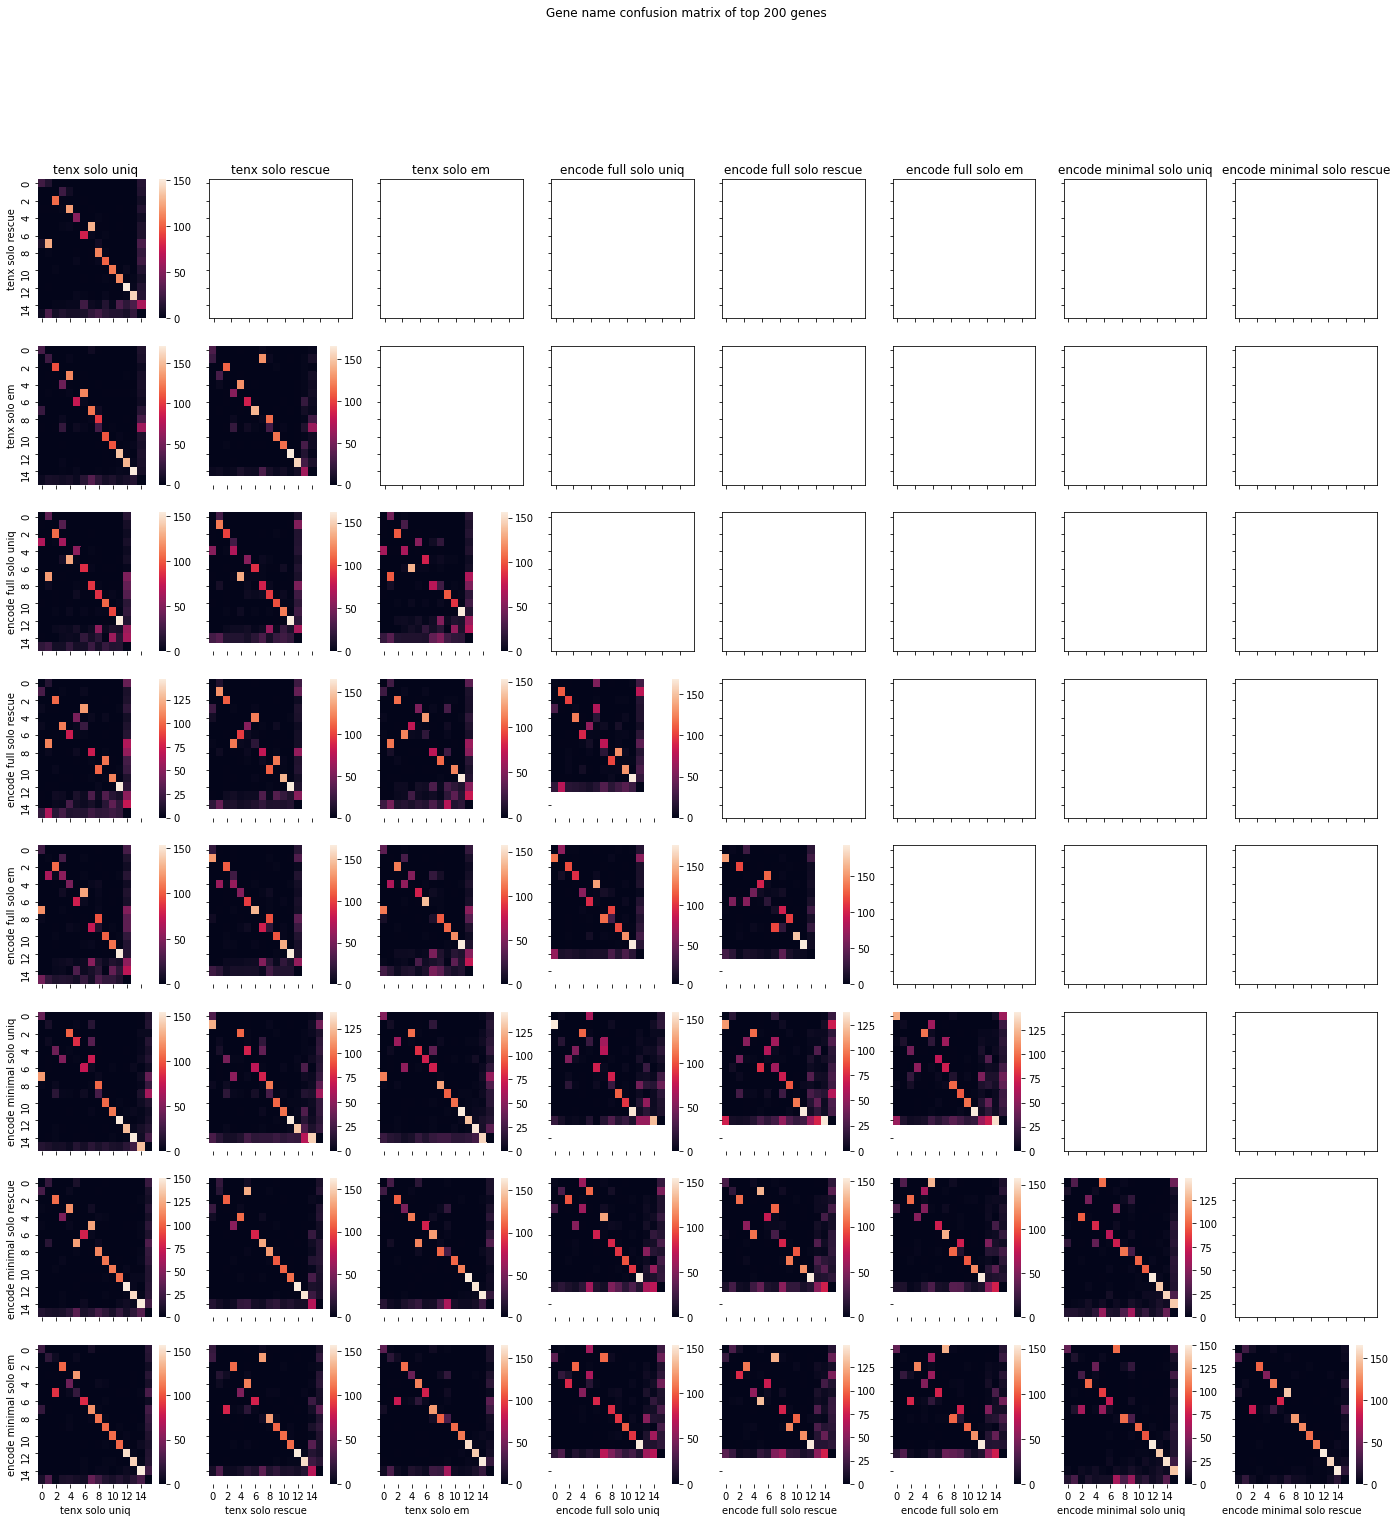

In [50]:
plot_algorithm_confusion(algorithm_top_gene_names, N=200)

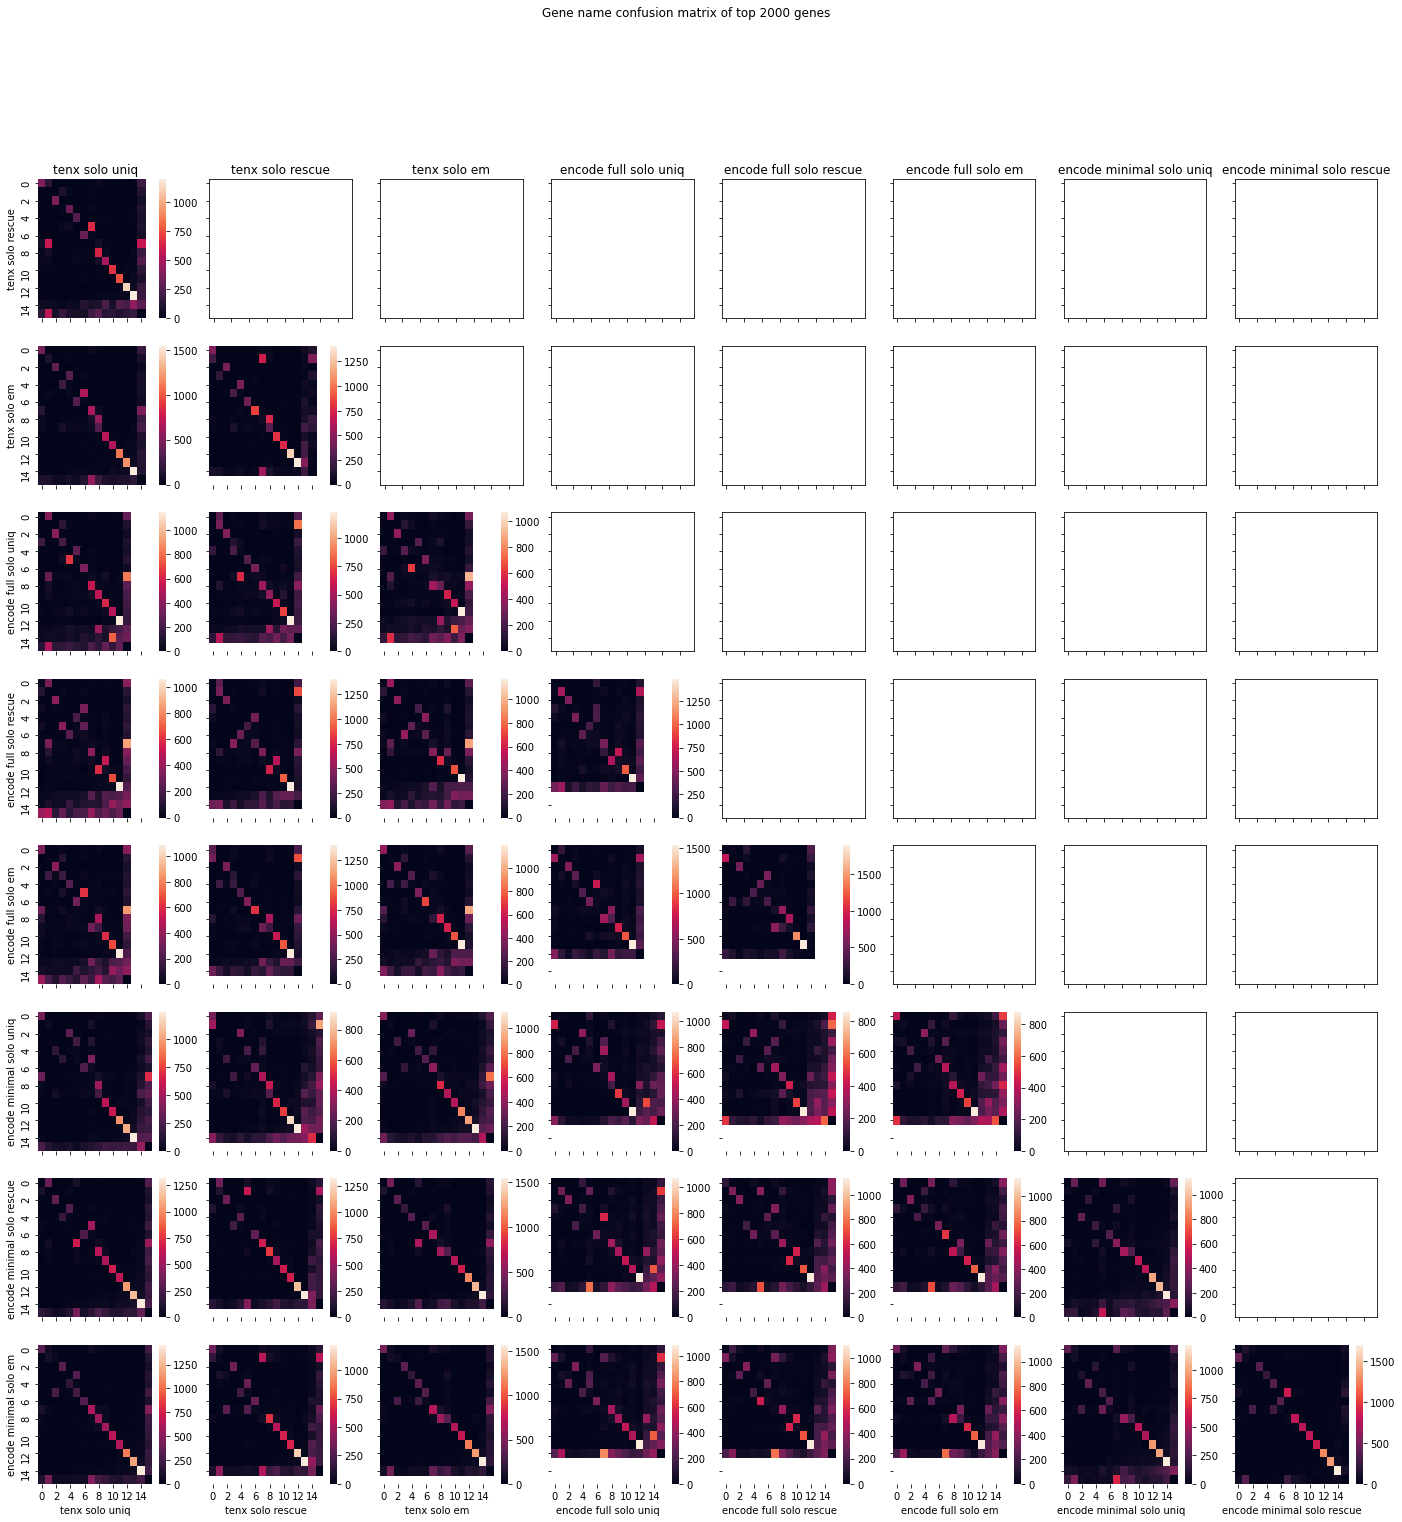

In [51]:
plot_algorithm_confusion(algorithm_top_gene_names, N=2000)

# Save h5 tables

In [52]:
for algorithm in algorithm_scanpy_filtered:
    run_dir, quantification, filtering, multiread = algorithm_roots[algorithm]
    h5ad_name = "{}_{}_{}.h5ad".format(quantification, "scanpy", multiread)
    algorithm_scanpy_filtered[algorithm].write_h5ad(run_dir / h5ad_name)